# Short-Horizon Crypto Microstructure (Binance REST-only)
### Signal Research & Backtesting Prototype (BTCUSDT, 1s, 10–60s horizons)

**Goal:** build a reproducible research pipeline (ingestion → microstructure proxy features → event-driven backtest with realistic costs → robustness/OOS → reporting) using **only** public Binance Spot REST data.

**Instrument:** BTCUSDT
**Frequency:** 1-second (klines 1s + aggTrades)
**Horizons:** $H \in \{10, 30, 60\}$ seconds
**Focus:** short-horizon microstructure signals with explicit assumptions and execution constraints.



## TL;DR (Key takeaways)

- **Reproducible pipeline** using public Binance Spot REST: `/api/v3/klines (1s)` + `/api/v3/aggTrades` → parquet → features → backtest → report.
- **Microstructure proxies (no historical L2):**
  - **SVI** (signed volume imbalance) from klines (taker-buy ratio).
  - **OFI-proxy** from aggTrades (taker buy base − taker sell base).
  - **CFI** (count-flow imbalance) and **CFI ratio** (normalized).
  - **Max-share** (intra-second concentration) as a proxy for dominant-trade behavior.
- **Cross-source consistency:** SVI and OFI are numerically equivalent (corr ≈ 1) and generate identical trades (Jaccard = 1) across tested horizons.
- **CFI captures different information:** moderate correlation vs SVI/OFI and low trade overlap, motivating its use as a complementary signal.
- **Empirical result:** gross edge per trade is small relative to transaction costs; net performance is dominated by fees and slippage under the assumed execution model.


## Constraints & honesty (methodology)

This project uses **only** public **Binance Spot REST** data.
No claims are made about historical level-2 order book reconstruction.

- **1s klines** (`/api/v3/klines`) as the core dataset.
- **aggTrades** (`/api/v3/aggTrades`) as an additional tape-level source.
- No microprice modeling, no queue position, no FIFO simulation: **no historical L2**.

### Execution model
- Signal is computed at time $t$.
- Entry executes at $t+1$ using the next-second `open`.
- Exit executes at $t+1+H$ (or via take-profit when enabled; monitored on `close`, filled on the next `open`).
- Costs: fee and slippage per side, modeled as a fixed round-trip cost:

$$
\text{cost} \;=\; \frac{2(\text{fee}_{bps} + \text{slippage}_{bps})}{10^4}
$$

### API safety / rate-limit handling
The ingestion pipeline is designed to be reproducible and robust:
- Deterministic pagination (no duplicates, no gaps).
- Retries for transient 5xx errors.
- Backoff on 429 (rate limits).
- Hard stop on 418 (ban risk).
- Raw responses cached on disk for idempotent re-runs.



In [1]:
from pathlib import Path
import os
import json
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

# --- Paths (adjust if notebook is not in notebooks/)
ROOT = Path("..").resolve() if (Path.cwd().name == "notebooks") else Path(".").resolve()

DATA_PROCESSED = ROOT / "data" / "processed"
REPORT_TABLES = ROOT / "reports" / "tables"
REPORT_FIGS   = ROOT / "reports" / "figures"

FEATURES_PATH = DATA_PROCESSED / "features_1s.parquet"
LB_PATH       = REPORT_TABLES / "summary_best_oos_all_runs.csv"

print("ROOT:", ROOT)
print("FEATURES:", FEATURES_PATH.exists(), FEATURES_PATH)
print("LEADERBOARD:", LB_PATH.exists(), LB_PATH)

# --- Plot defaults (clean & readable)
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.25
plt.rcParams["font.size"] = 11


ROOT: /Users/noelp/PycharmProjects/microstructure-signal-research
FEATURES: True /Users/noelp/PycharmProjects/microstructure-signal-research/data/processed/features_1s.parquet
LEADERBOARD: True /Users/noelp/PycharmProjects/microstructure-signal-research/reports/tables/summary_best_oos_all_runs.csv


In [2]:
import sys
import platform

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())

# optional: library versions
import pandas, numpy
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)

# optional: git commit (if in a git repo)
import subprocess
try:
    commit = subprocess.check_output(["git", "rev-parse", "--short", "HEAD"], cwd=str(ROOT)).decode().strip()
    print("git commit:", commit)
except Exception:
    print("git commit: (not available)")


Python: 3.11.5
Platform: macOS-14.2.1-arm64-arm-64bit
pandas: 3.0.0
numpy: 2.4.1
git commit: ba25940


## Reproducing the pipeline (commands)

> Key outputs live in:
- `data/processed/` → `bars_1s.parquet`, `trades_1s.parquet`, `features_1s.parquet`
- `reports/tables/<run_name>/` → `best_oos.csv`, `grid_tune_*.csv`, `trades_test_H*.csv`
- `reports/figures/` → report plots

Example (adjust inputs to your local paths):

```bash
# 1) build 1s trades from aggTrades (if applicable)
python -m src.build_trades_1s --inputs data/raw/...parquet --out data/processed/trades_1s.parquet

# 2) compute features
python -m src.features \
  --bars data/processed/bars_1s.parquet \
  --trades_1s data/processed/trades_1s.parquet \
  --out data/processed/features_1s.parquet

# 3) run report aggregation + figures
python -m src.report \
  --runs_root reports/tables \
  --out_fig_dir reports/figures \
  --out_tables_dir reports/tables \
  --value_col alpha_avg_pnl \
  --plot_3d \
  --top_k_overlay 5 \
  --overlay_metric alpha_avg_pnl \
  --features data/processed/features_1s.parquet



---

# 1. Data: Binance Spot REST (1-second) + sanity checks

### Sources
- **1s klines** (`/api/v3/klines`): OHLCV + `n_trades` + taker-buy volumes.
- **aggTrades** (`/api/v3/aggTrades`): tape prints used to build 1s aggregates (counts + buy/sell volume).

### Motivation
- **1s klines**: compact, easy to ingest, sufficient for basic proxies (intensity, taker-buy ratio).
- **aggTrades**: adds tape-level detail (buy/sell, counts, concentration), enabling alternative proxies (OFI/CFI/max-share).

### Required sanity checks
- UTC, tz-aware, monotonic, no duplicates.
- Full 1s grid coverage (or a documented imputation policy).
- Imputation flags (`is_imputed`, `is_imputed_trades`) to quantify impact on decisions.


In [3]:
df = pd.read_parquet(FEATURES_PATH)
print("shape:", df.shape)
print("index:", type(df.index), "tz:", df.index.tz)
print("cols (first 25):", df.columns.tolist()[:25])
df.head(3)


shape: (86401, 46)
index: <class 'pandas.DatetimeIndex'> tz: UTC
cols (first 25): ['open', 'high', 'low', 'close', 'volume', 'quote_volume', 'n_trades', 'taker_buy_base', 'taker_buy_quote', 'is_imputed', 'n_aggtrades_1s', 'base_qty_1s', 'quote_qty_1s', 'taker_buy_base_1s', 'taker_sell_base_1s', 'buy_count_1s', 'sell_count_1s', 'max_qty_1s', 'ofi_base_1s', 'ofi_ratio_1s', 'ofi_count_1s', 'mean_qty_1s', 'max_share_1s', 'is_imputed_trades', 'r1']


,open,high,low,close,volume,quote_volume,n_trades,taker_buy_base,taker_buy_quote,is_imputed,n_aggtrades_1s,base_qty_1s,quote_qty_1s,taker_buy_base_1s,taker_sell_base_1s,buy_count_1s,sell_count_1s,max_qty_1s,ofi_base_1s,ofi_ratio_1s,ofi_count_1s,mean_qty_1s,max_share_1s,is_imputed_trades,r1,rv_60,intensity_60,tbr,sv,svi_60,z_svi_60_600,z_svi_60_600_lag1,ofi_60,z_ofi_60_600,z_ofi_60_600_lag1,intensity_trades_60,cfi_1s,cfi_ratio_1s,cfi_60,z_cfi_60_600,z_cfi_60_600_lag1,cfi_ratio_60,z_cfi_ratio_60_600,z_cfi_ratio_60_600_lag1,z_max_share_60_600,z_max_share_60_600_lag1
2026-01-22 00:00:00+00:00,89454.73,89454.73,89454.72,89454.73,0.07350,6574.922009,27,0.00887,793.463455,False,12,0.07350,6574.922009,0.00887,0.06463,10,2,0.06260,-0.05576,-0.758639,8,0.006125,0.851701,False,NaN,NaN,NaN,0.120680,-0.05576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-22 00:00:01+00:00,89454.73,89454.73,89454.72,89454.72,0.01308,1170.067781,9,0.00433,387.338981,False,9,0.01308,1170.067781,0.00433,0.00875,5,4,0.00728,-0.00442,-0.337920,1,0.001453,0.556575,False,-1.117884e-07,NaN,NaN,0.331040,-0.00442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-22 00:00:02+00:00,89454.73,89457.43,89454.72,89457.43,0.33591,30048.834753,106,0.30227,27039.577972,False,21,0.33591,30048.834753,0.30227,0.03364,18,3,0.12113,0.26863,0.799708,15,0.015996,0.360603,False,3.029420e-05,NaN,NaN,0.899854,0.26863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,0.714286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dataset time window

To keep scope tight while still enabling out-of-sample evaluation, a single contiguous block of 1-second data is used.

- **Instrument:** BTCUSDT (Binance Spot)
- **Granularity:** 1s bars (core) + 1s aggTrades aggregation (optional, for tape-level proxies)
- **Test horizons:** $H \in \{10, 30, 60\}$ seconds

Below, the exact timestamp range of the processed dataset is reported.



In [4]:
t0, t1 = df.index.min(), df.index.max()
hours = (t1 - t0).total_seconds() / 3600

print("features:", FEATURES_PATH)
print("start:", t0)
print("end:  ", t1)
print("duration_hours:", hours)
print("rows:", len(df), "cols:", df.shape[1])



features: /Users/noelp/PycharmProjects/microstructure-signal-research/data/processed/features_1s.parquet
start: 2026-01-22 00:00:00+00:00
end:   2026-01-23 00:00:00+00:00
duration_hours: 24.0
rows: 86401 cols: 46


In [5]:
# Basic index checks
assert isinstance(df.index, pd.DatetimeIndex)
assert df.index.tz is not None, "Index must be tz-aware (UTC)."
assert df.index.is_monotonic_increasing, "Index must be monotonic increasing."

dup = df.index.duplicated().sum()
print("duplicate timestamps:", int(dup))

# Missing seconds check (relative to full range)
full = pd.date_range(df.index.min(), df.index.max(), freq="1s", tz=df.index.tz)
missing = full.difference(df.index)
print("rows:", len(df), "full_grid:", len(full), "missing_seconds:", len(missing), f"({len(missing)/len(full):.4%})")

# Show a few missing timestamps if any
if len(missing) > 0:
    print("first missing:", missing[:10].tolist())


duplicate timestamps: 0
rows: 86401 full_grid: 86401 missing_seconds: 0 (0.0000%)


### Train/Val/Test split (time-ordered, no leakage)

A **time-based split** is used to avoid leakage and to mimic a realistic research → deployment workflow.

- **Split:** 60% train / 20% validation / 20% test
- **Rule:** parameters (threshold $q$, take-profit $pt$) are selected **only** on the validation set (or train if no val),
  then evaluated **once** on the test set.


### Dataset window & time split (chronological)
- **Window:** 2026-01-22 00:00:00 UTC → 2026-01-23 00:00:00 UTC (24h of 1s data)
- **Splits (by time, no shuffling):**
  - Train: start → **2026-01-22 14:23:59 UTC** (60%)
  - Validation: **2026-01-22 14:24:00** → **2026-01-22 19:11:59 UTC** (20%)
  - Test (OOS): **2026-01-22 19:12:00 UTC** → end (20%)

Below, the exact row counts and timestamp ranges implied by the split are computed on the current dataset.

In [6]:
import numpy as np

split = (0.6, 0.2, 0.2)
n = len(df)

cut1 = int(np.floor(split[0] * n))
cut2 = int(np.floor((split[0] + split[1]) * n))

train = df.iloc[:cut1]
val   = df.iloc[cut1:cut2]
test  = df.iloc[cut2:]

print("split:", split)
print("n_total:", n)
print("n_train:", len(train), "from", train.index.min(), "to", train.index.max())
print("n_val:  ", len(val),   "from", val.index.min(),   "to", val.index.max())
print("n_test: ", len(test),  "from", test.index.min(),  "to", test.index.max())


split: (0.6, 0.2, 0.2)
n_total: 86401
n_train: 51840 from 2026-01-22 00:00:00+00:00 to 2026-01-22 14:23:59+00:00
n_val:   17280 from 2026-01-22 14:24:00+00:00 to 2026-01-22 19:11:59+00:00
n_test:  17281 from 2026-01-22 19:12:00+00:00 to 2026-01-23 00:00:00+00:00


In [7]:
bar_imp = float(df["is_imputed"].mean()) if "is_imputed" in df.columns else np.nan
trd_imp = float(df["is_imputed_trades"].mean()) if "is_imputed_trades" in df.columns else np.nan

print("is_imputed (bars) rate:", bar_imp)
print("is_imputed_trades rate:", trd_imp)

# Optional: where imputation clusters
if "is_imputed_trades" in df.columns:
    imp_idx = df.index[df["is_imputed_trades"].astype(bool)]
    print("imputed_trades count:", len(imp_idx))
    if len(imp_idx) > 0:
        print("first 5:", imp_idx[:5].tolist())


is_imputed (bars) rate: 0.0
is_imputed_trades rate: 0.06083262925197625
imputed_trades count: 5256
first 5: [Timestamp('2026-01-22 00:00:17+0000', tz='UTC'), Timestamp('2026-01-22 00:03:40+0000', tz='UTC'), Timestamp('2026-01-22 00:03:49+0000', tz='UTC'), Timestamp('2026-01-22 00:03:51+0000', tz='UTC'), Timestamp('2026-01-22 00:04:59+0000', tz='UTC')]


### Do strategies concentrate decisions on imputed seconds?

Global imputation rates are useful, but what matters for backtests is whether **trade decisions** disproportionately occur on imputed seconds.

Below, for each run and horizon $H$, the following are computed:
- number of test trades
- fraction of decision timestamps that fall on `is_imputed_trades == True`

This is a quick robustness check and a common failure mode in high-frequency research (signals accidentally “trade the gaps”).



In [8]:
import os, glob

runs = sorted({os.path.dirname(p) for p in glob.glob(str(REPORT_TABLES / "*" / "best_oos.csv"))})

rows = []
for run_dir in runs:
    run = os.path.basename(run_dir)
    for H in [10, 30, 60]:
        p = os.path.join(run_dir, f"trades_test_H{H}.csv")
        if not os.path.exists(p):
            continue
        t = pd.read_csv(p)
        if len(t) == 0:
            continue

        dt = pd.to_datetime(t["decision_time"])
        frac_tr = float(df.reindex(dt)["is_imputed_trades"].mean()) if "is_imputed_trades" in df.columns else np.nan

        rows.append({
            "run": run,
            "H": int(H),
            "n_trades": int(len(t)),
            "decision_on_imputed_trades": frac_tr,
        })

imp_decisions = pd.DataFrame(rows).sort_values(["H", "decision_on_imputed_trades"], ascending=[True, False]).reset_index(drop=True)
imp_decisions


,run,H,n_trades,decision_on_imputed_trades
0,cfi_ratio_contrarian,10,52,0.134615
1,cfi_ratio_trend,10,52,0.134615
2,ofi_gate_low,10,53,0.075472
3,svi_gate_low,10,53,0.075472
4,ofi_base,10,54,0.074074
5,ofi_pessimistic_cost,10,54,0.074074
6,svi_base,10,54,0.074074
7,svi_pessimistic_cost,10,54,0.074074
8,max_share_contrarian,10,38,0.052632
9,ensemble_double_gate,10,27,0.037037


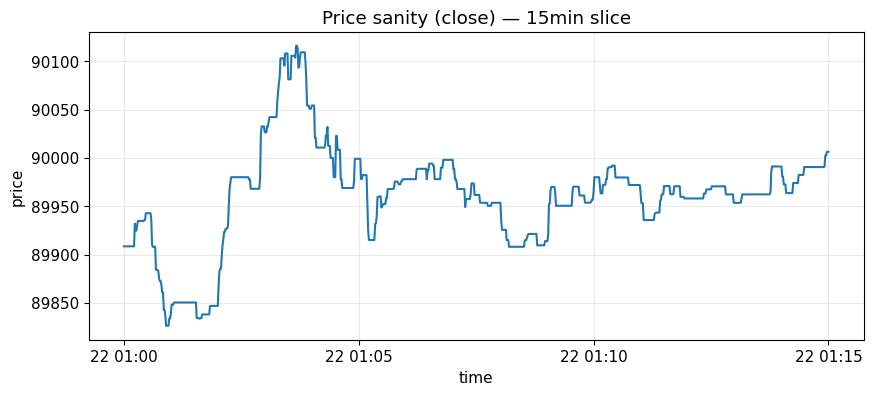

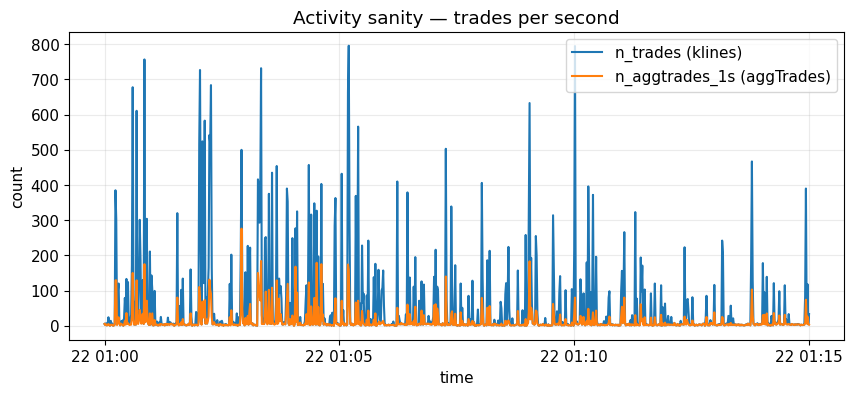

In [9]:
# pick a short slice to visualize
start = df.index.min() + pd.Timedelta(hours=1)
end   = start + pd.Timedelta(minutes=15)
sl = df.loc[start:end].copy()

fig, ax = plt.subplots()
ax.plot(sl.index, sl["close"].astype(float))
ax.set_title("Price sanity (close) — 15min slice")
ax.set_xlabel("time")
ax.set_ylabel("price")
plt.show()

# activity: n_trades + optional n_aggtrades_1s
fig, ax = plt.subplots()
ax.plot(sl.index, sl["n_trades"].astype(float), label="n_trades (klines)")
if "n_aggtrades_1s" in sl.columns:
    ax.plot(sl.index, sl["n_aggtrades_1s"].astype(float), label="n_aggtrades_1s (aggTrades)")
ax.set_title("Activity sanity — trades per second")
ax.set_xlabel("time")
ax.set_ylabel("count")
ax.legend(loc="best")
plt.show()


### Data quality notes
- `is_imputed (bars)` flags seconds filled when enforcing a 1s grid for klines (if any).
- `is_imputed_trades` flags seconds where aggTrades 1s aggregates were imputed (e.g., missing prints).

In the signal + backtest analysis:
- The fraction of decisions landing on imputed seconds is measured explicitly.
- (Optional) robustness variants can skip imputed trades (`--skip_imputed_trades`) to test sensitivity.




---

# 2. Microstructure intuition: what we measure (and what we don’t)

## Why this section exists
In microstructure research, it’s easy to over-claim signal meaning. The goal here is the opposite:
**be precise about what is observable from Binance REST-only tape-like data**, and what is not.

### What we do NOT have (and therefore do NOT claim)
- No historical limit order book (L2) replay → no true queue position, no FIFO fills.
- No microprice / depth imbalance / order book slope features (requires L2).
- No claims about “true” classic OFI measured from L2 events.

### What we DO have (REST-only, defensible)
- 1-second klines include:
  - trade count (`n_trades`)
  - taker-buy volumes (base + quote)
- aggTrades provide tape prints (buyer-initiated vs seller-initiated flags) → we can build:
  - buy/sell volume per second
  - buy/sell count per second
  - concentration metrics (largest trade share within a second)

**Key idea:** we build *proxies* that are consistent with microstructure intuition, while staying honest about observability.


## Proxy signals (definitions)

Let $t$ index **seconds** on a 1s grid.

### Common building blocks
- **Trade intensity (liquidity / activity proxy)**
$$
\text{intensity}_{W}(t) = \sum_{k=0}^{W-1} n\_trades(t-k)
$$

- **Taker-buy ratio (aggressor flow proxy from klines)**
$$
\text{TBR}(t) = \frac{\text{taker\_buy\_base}(t)}{\max(\text{volume}(t), \varepsilon)}
$$

- **Signed volume per second (simple tape sign proxy)**
$$
\text{SV}(t) = (2\cdot \text{TBR}(t) - 1)\cdot \text{volume}(t)
$$

### SVI (Signed Volume Imbalance) from klines
Rolling signed volume:
$$
\text{SVI}_{W}(t) = \sum_{k=0}^{W-1} \text{SV}(t-k)
$$

### OFI-proxy from aggTrades (volume-flow)
If we aggregate aggTrades into 1s buckets:
- $V_b(t)$: buyer-initiated base volume in second $t$
- $V_s(t)$: seller-initiated base volume in second $t$

Then a simple volume-flow imbalance:
$$
\text{OFI}_{1s}(t) = V_b(t) - V_s(t)
$$

### CFI (Count-Flow Imbalance) from aggTrades
Let:
- $C_b(t)$: number of buyer-initiated prints in second $t$
- $C_s(t)$: number of seller-initiated prints in second $t$

Then:
$$
\text{CFI}_{1s}(t) = C_b(t) - C_s(t)
$$

### CFI ratio (normalized)
A bounded version that can be more stable:
$$
\text{CFI\_ratio}(t) = \frac{C_b(t) - C_s(t)}{\max(C_b(t) + C_s(t), 1)}
$$

### Max-share (intra-second concentration)
Let $q_i(t)$ be the base quantity of each aggTrade inside second $t$, and $Q(t)=\sum_i q_i(t)$.
$$
\text{max\_share}(t) = \frac{\max_i q_i(t)}{\max(Q(t), \varepsilon)}
$$

### Z-scoring + lag (causality)
We standardize a rolling feature $x(t)$ using a longer lookback $L$ (e.g. 600s), and apply a conservative lag:
$$
z(t) = \frac{x(t) - \mu_L(t)}{\sigma_L(t)}, \qquad z\_{\text{lag1}}(t) = z(t-1)
$$

> We trade using the signal at decision time $t$, entering at $t+1$.


In [10]:
core_cols = [
    "z_svi_60_600_lag1",
    "z_ofi_60_600_lag1",
    "z_cfi_60_600_lag1",
    "z_cfi_ratio_60_600_lag1",
    "z_max_share_60_600_lag1",
]

missing = [c for c in core_cols if c not in df.columns]
print("missing core cols:", missing)

df[core_cols].describe().T


missing core cols: []


,count,mean,std,min,25%,50%,75%,max
z_svi_60_600_lag1,85742.0,-0.008036,1.228803,-16.155344,-0.554425,-0.022746,0.524333,14.381776
z_ofi_60_600_lag1,85742.0,-0.008036,1.228803,-16.155344,-0.554425,-0.022746,0.524333,14.381776
z_cfi_60_600_lag1,85742.0,-0.008322,1.127099,-6.104230,-0.656184,0.033434,0.660936,6.406560
z_cfi_ratio_60_600_lag1,85742.0,0.007523,1.164314,-4.575594,-0.804028,-0.003468,0.796602,4.220704
z_max_share_60_600_lag1,85742.0,0.009030,1.149835,-4.286716,-0.746420,0.031587,0.778843,4.324647


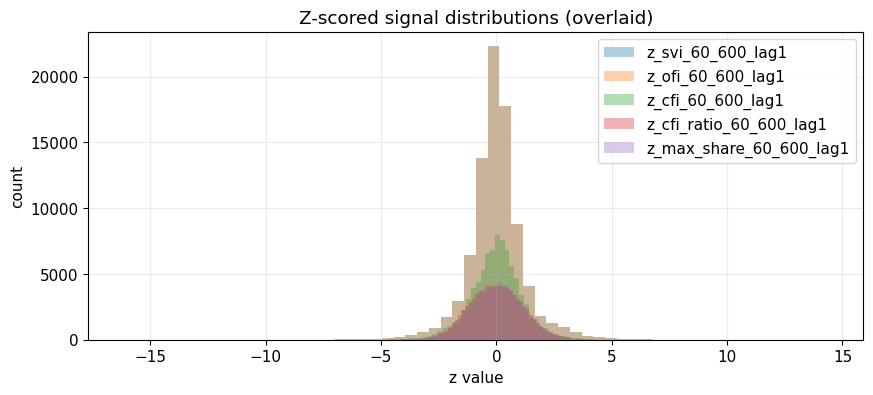

In [11]:
cols = core_cols
X = df[cols].astype(float).dropna()

fig, ax = plt.subplots(figsize=(10, 4))
for c in cols:
    ax.hist(X[c].to_numpy(), bins=60, alpha=0.35, label=c)
ax.set_title("Z-scored signal distributions (overlaid)")
ax.set_xlabel("z value")
ax.set_ylabel("count")
ax.legend(loc="best")
plt.show()


In [12]:
cols = core_cols
X = df[cols].astype(float).dropna()
print("rows after dropna:", len(X))

corr = X.corr()
display(corr)

# Pairwise diagnostics: correlation, mean abs diff, exact equality rate
arr = X.to_numpy()
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        a, b = arr[:, i], arr[:, j]
        c = float(np.corrcoef(a, b)[0, 1])
        mad = float(np.mean(np.abs(a - b)))
        peq = float(np.mean(a == b))
        print(f"\nPAIR {cols[i]} vs {cols[j]}")
        print(" corr:", c)
        print(" mean_abs_diff:", mad)
        print(" pct_exact_equal:", peq)


rows after dropna: 85742


,z_svi_60_600_lag1,z_ofi_60_600_lag1,z_cfi_60_600_lag1,z_cfi_ratio_60_600_lag1,z_max_share_60_600_lag1
z_svi_60_600_lag1,1.000000,1.000000,0.623511,0.187363,0.031781
z_ofi_60_600_lag1,1.000000,1.000000,0.623511,0.187363,0.031781
z_cfi_60_600_lag1,0.623511,0.623511,1.000000,0.437848,0.012271
z_cfi_ratio_60_600_lag1,0.187363,0.187363,0.437848,1.000000,-0.050261
z_max_share_60_600_lag1,0.031781,0.031781,0.012271,-0.050261,1.000000



PAIR z_svi_60_600_lag1 vs z_ofi_60_600_lag1
 corr: 0.9999999999999998
 mean_abs_diff: 6.8388192634320335e-15
 pct_exact_equal: 0.0540108698187586

PAIR z_svi_60_600_lag1 vs z_cfi_60_600_lag1
 corr: 0.6235108556813598
 mean_abs_diff: 0.7270647528182349
 pct_exact_equal: 0.0

PAIR z_svi_60_600_lag1 vs z_cfi_ratio_60_600_lag1
 corr: 0.1873634428389431
 mean_abs_diff: 1.1251884287519407
 pct_exact_equal: 0.0

PAIR z_svi_60_600_lag1 vs z_max_share_60_600_lag1
 corr: 0.031781394750873056
 mean_abs_diff: 1.2500108111374324
 pct_exact_equal: 0.0

PAIR z_ofi_60_600_lag1 vs z_cfi_60_600_lag1
 corr: 0.6235108556813603
 mean_abs_diff: 0.7270647528182369
 pct_exact_equal: 0.0

PAIR z_ofi_60_600_lag1 vs z_cfi_ratio_60_600_lag1
 corr: 0.18736344283894305
 mean_abs_diff: 1.1251884287519434
 pct_exact_equal: 0.0

PAIR z_ofi_60_600_lag1 vs z_max_share_60_600_lag1
 corr: 0.03178139475087324
 mean_abs_diff: 1.2500108111374357
 pct_exact_equal: 0.0

PAIR z_cfi_60_600_lag1 vs z_cfi_ratio_60_600_lag1
 corr:

n: 85742
corr: 0.9999999999999998
mean_abs_diff: 6.8388192634320335e-15
max_abs_diff: 7.407408020299044e-13


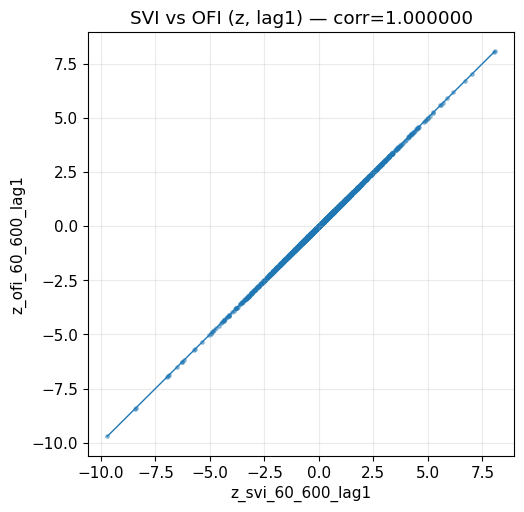

In [13]:
a = df["z_svi_60_600_lag1"].astype(float)
b = df["z_ofi_60_600_lag1"].astype(float)
m = a.notna() & b.notna()
a2, b2 = a[m].to_numpy(), b[m].to_numpy()

c = float(np.corrcoef(a2, b2)[0, 1])
mad = float(np.mean(np.abs(a2 - b2)))
mx  = float(np.max(np.abs(a2 - b2)))

print("n:", int(m.sum()))
print("corr:", c)
print("mean_abs_diff:", mad)
print("max_abs_diff:", mx)

# scatter (downsample for speed/clarity)
idx = np.linspace(0, len(a2) - 1, num=min(5000, len(a2)), dtype=int)
x, y = a2[idx], b2[idx]

fig, ax = plt.subplots(figsize=(5.5, 5.5))
ax.scatter(x, y, s=6, alpha=0.4)
lo = float(min(x.min(), y.min()))
hi = float(max(x.max(), y.max()))
ax.plot([lo, hi], [lo, hi], linewidth=1)  # y=x
ax.set_title(f"SVI vs OFI (z, lag1) — corr={c:.6f}")
ax.set_xlabel("z_svi_60_600_lag1")
ax.set_ylabel("z_ofi_60_600_lag1")
plt.show()


## Interpretation (empirical observations)

### 1) Cross-source replication (SVI ≈ OFI)
SVI (from 1s klines taker-buy ratio) and OFI-proxy (from aggTrades buy/sell volumes) are **numerically equivalent up to floating point precision** in this dataset.
This acts as a consistency check: **two different endpoints reproduce the same imbalance signal**.

### 2) CFI is different information
CFI and CFI_ratio show **materially lower correlation** vs SVI/OFI.
That suggests CFI captures a different microstructure dimension: **count imbalance**, not volume imbalance.

### 3) max-share is mostly orthogonal
Max-share is weakly correlated with the others, making it a natural candidate for use in simple ensembles.


In [14]:
import itertools

def load_decision_set(run: str, H: int):
    p = REPORT_TABLES / run / f"trades_test_H{H}.csv"
    if not p.exists():
        return None
    t = pd.read_csv(p)
    if len(t) == 0:
        return set()
    return set(pd.to_datetime(t["decision_time"]))

def jaccard(A: set, B: set) -> float:
    union = len(A | B)
    return (len(A & B) / union) if union else float("nan")

runs = [
    "svi_base", "ofi_base",
    "cfi_base", "cfi_ratio_trend", "cfi_ratio_contrarian",
    "max_share_contrarian",
    "ensemble_cfi_maxshare", "ensemble_double_gate",
]

Hs = [10, 30, 60]

# Pairs we ALWAYS want to see (even if overlap is small)
key_pairs = [
    ("svi_base", "ofi_base"),          # replication
    ("svi_base", "cfi_base"),          # CFI vs SVI
    ("ofi_base", "cfi_base"),          # CFI vs OFI
    ("svi_base", "max_share_contrarian"),
    ("cfi_base", "max_share_contrarian"),
    ("cfi_ratio_trend", "cfi_ratio_contrarian"),
    ("ensemble_cfi_maxshare", "ensemble_double_gate"),
]

for H in Hs:
    sets = {}
    for r in runs:
        s = load_decision_set(r, H)
        if s is not None:
            sets[r] = s

    ok = list(sets.keys())
    print(f"\n=== H={H} (runs={len(ok)}) ===")
    for r in ok:
        print(f"{r:25s} n={len(sets[r])}")

    # --- Key overlaps (always shown)
    print("\nKey overlaps (always shown):")
    for a, b in key_pairs:
        if a in sets and b in sets:
            A, B = sets[a], sets[b]
            inter = len(A & B)
            union = len(A | B)
            jac = jaccard(A, B)
            print(f"{a:25s} vs {b:25s} jaccard={jac:.3f} inter={inter:3d} union={union:3d}")

    # --- Broad scan (only show meaningful overlaps)
    print("\nOther overlaps (filtered, jaccard > 0.20):")
    shown = 0
    for a, b in itertools.combinations(ok, 2):
        if (a, b) in key_pairs or (b, a) in key_pairs:
            continue
        A, B = sets[a], sets[b]
        jac = jaccard(A, B)
        if jac > 0.20:
            inter = len(A & B)
            union = len(A | B)
            print(f"{a:25s} vs {b:25s} jaccard={jac:.3f} inter={inter:3d} union={union:3d}")
            shown += 1
    if shown == 0:
        print("(none above threshold)")



=== H=10 (runs=8) ===
svi_base                  n=54
ofi_base                  n=54
cfi_base                  n=45
cfi_ratio_trend           n=52
cfi_ratio_contrarian      n=52
max_share_contrarian      n=38
ensemble_cfi_maxshare     n=36
ensemble_double_gate      n=27

Key overlaps (always shown):
svi_base                  vs ofi_base                  jaccard=1.000 inter= 54 union= 54
svi_base                  vs cfi_base                  jaccard=0.042 inter=  4 union= 95
ofi_base                  vs cfi_base                  jaccard=0.042 inter=  4 union= 95
svi_base                  vs max_share_contrarian      jaccard=0.000 inter=  0 union= 92
cfi_base                  vs max_share_contrarian      jaccard=0.000 inter=  0 union= 83
cfi_ratio_trend           vs cfi_ratio_contrarian      jaccard=1.000 inter= 52 union= 52
ensemble_cfi_maxshare     vs ensemble_double_gate      jaccard=0.750 inter= 27 union= 36

Other overlaps (filtered, jaccard > 0.20):
(none above threshold)

=== H=30

## Why trade overlap matters (beyond correlation)

Correlation is a **continuous** comparison, but the strategy acts on **discrete events** (thresholds + gates → “enter / do nothing” decisions).
So we also compare **decision overlap** using the Jaccard index:

$$J(A,B)=\frac{|A\cap B|}{|A\cup B|}$$

**Reading the output above:**
- **SVI vs OFI** shows near-perfect replication (high overlap across horizons) → strong *cross-source sanity check*.
- **CFI vs SVI/OFI** overlaps much less → suggests **incremental information** (count-imbalance vs volume-imbalance).
- **Max-share** triggers largely disjoint decisions → useful as an **orthogonal ensemble ingredient**.




---

# 3. Labeling / target (aligned with execution)

The backtest in this project is **event-driven** and does **not** require a precomputed “future return label”.
Trades are simulated directly using execution prices:

- Signal observed at decision time $t$ (using features available up to $t$).
- Entry executes at the next second open:
  $$p_{\text{in}}(t)=\text{open}_{t+1}$$
- Time-based exit (if no take-profit) executes at:
  $$p_{\text{out}}(t,H)=\text{open}_{t+1+H}$$
- Take-profit (optional) is **path-dependent**:
  it is *monitored* on $\text{close}$ during the holding window, but *filled* at the next $\text{open}$.

## A diagnostic label (optional, for analysis only)

For distributional analysis (and optionally IC-style diagnostics), we define the **time-exit** gross return:

$$r_H(t)=\frac{p_{\text{out}}(t,H)}{p_{\text{in}}(t)}-1$$

This is **aligned with the backtest execution prices** (open-to-open), but it does **not** encode take-profit exits.
Actual PnL results come from the non-overlapping trade simulation, not from this label.

> Note: $r_H(t)$ is defined for every second, so it is **overlapping** by construction.
> The backtest trades are **non-overlapping** (a new trade starts only after the previous one exits).



In [15]:
Hs = [10, 30, 60]

# The project executes on bar "open" by default (cfg.exec_price_col="open")
assert "open" in df.columns, "Expected 'open' in features dataframe (execution price)."

open_px = df["open"].astype(float)

for H in Hs:
    entry = open_px.shift(-1)          # open_{t+1}
    exit_ = open_px.shift(-(1 + H))    # open_{t+1+H}
    df[f"fwd_ret_H{H}"] = exit_ / entry - 1.0

print("Added columns:", [f"fwd_ret_H{H}" for H in Hs])
df[[ "open" ] + [f"fwd_ret_H{H}" for H in Hs]].head(3)


Added columns: ['fwd_ret_H10', 'fwd_ret_H30', 'fwd_ret_H60']


,open,fwd_ret_H10,fwd_ret_H30,fwd_ret_H60
2026-01-22 00:00:00+00:00,89454.73,0.000104,0.000188,0.000480
2026-01-22 00:00:01+00:00,89454.73,0.000224,0.000187,0.000164
2026-01-22 00:00:02+00:00,89454.73,0.000362,0.000227,0.000134


In [16]:
rows = []
for H in Hs:
    x = df[f"fwd_ret_H{H}"].astype(float).dropna()
    rows.append({
        "H": H,
        "n": int(len(x)),
        "mean_bps": float(x.mean() * 1e4),
        "std_bps": float(x.std() * 1e4),
        "p01_bps": float(x.quantile(0.01) * 1e4),
        "p50_bps": float(x.quantile(0.50) * 1e4),
        "p99_bps": float(x.quantile(0.99) * 1e4),
        "pct_exact_zero": float((x == 0.0).mean()),
    })

pd.DataFrame(rows).set_index("H")



,n,mean_bps,std_bps,p01_bps,p50_bps,p99_bps,pct_exact_zero
H,,,,,,,
10,86390,0.001310,2.068887,-6.254873,0.0,6.261465,0.185114
30,86370,0.003501,3.665152,-10.468941,0.0,10.105700,0.064224
60,86340,0.005639,5.228738,-15.481065,0.0,14.981922,0.020859


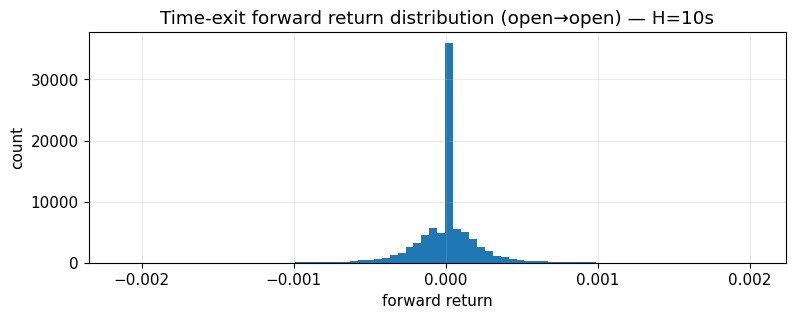

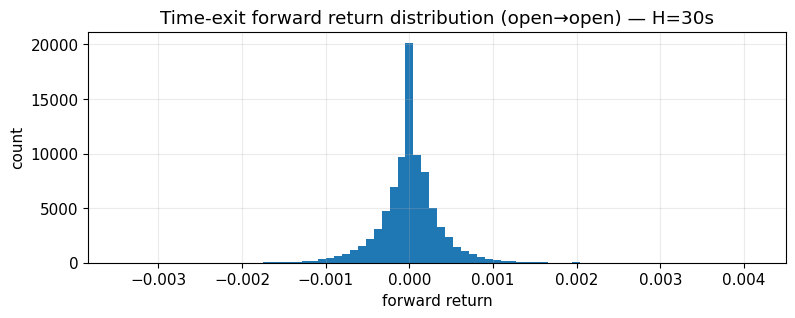

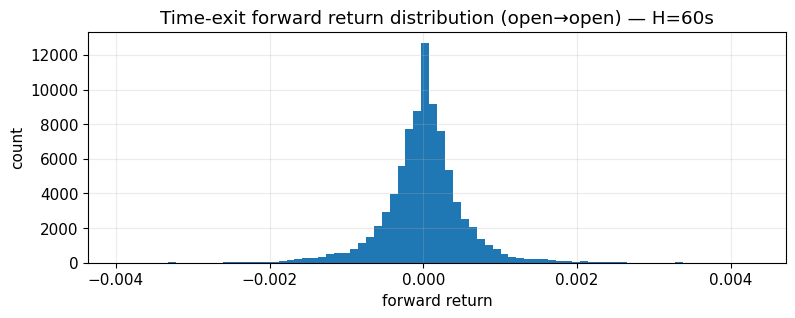

In [17]:
for H in Hs:
    x = df[f"fwd_ret_H{H}"].astype(float).dropna()
    fig, ax = plt.subplots(figsize=(9, 3))
    ax.hist(x, bins=80)
    ax.set_title(f"Time-exit forward return distribution (open→open) — H={H}s")
    ax.set_xlabel("forward return")
    ax.set_ylabel("count")
    plt.show()


## Take-profit vs fixed-horizon labels

The diagnostic label $r_H(t)$ assumes a deterministic exit at $\text{open}_{t+1+H}$.

With take-profit enabled, exits become **path-dependent**:
- unrealized PnL is *checked* on $\text{close}_{t+k}$ during the hold,
- if the threshold is first reached, the trade is *filled* at $\text{open}_{t+k+1}$.

Therefore:
- $r_H(t)$ is best treated as a **distributional sanity check** (open→open difficulty / noise level),
- while any strategy claim must come from the **event-driven simulator** (non-overlapping trades + the actual execution rule).




---

# 4. Backtest methodology (event-driven, costs, gates, tuning)

This project evaluates signals via an **event-driven simulator** that matches the actual execution assumptions used in `src/backtest.py`.

## Trade lifecycle (non-overlapping)
At each second $t$ (the **decision time**) we compute a signal $s(t)$ from one feature column or a weighted ensemble.

**Side decision (threshold $q$):**
- **trend**: go long if $s(t) > q$, short if $s(t) < -q$
- **contrarian**: invert the mapping

**Execution timeline:**
- Entry is executed at the next-second open:
  $$t_{\text{in}} = t+1,\quad p_{\text{in}}=\text{open}_{t_{\text{in}}}$$
- If no take-profit triggers, exit is executed at:
  $$t_{\text{out}} = t_{\text{in}} + H,\quad p_{\text{out}}=\text{open}_{t_{\text{out}}}$$

**Take-profit (path-dependent, optional):**
- We monitor unrealized return on the **close** inside the holding window.
- If the TP threshold is first reached at some $t_{\text{check}}$, the fill happens at the **next open**:
  $$t_{\text{out}} = t_{\text{check}} + 1,\quad p_{\text{out}}=\text{open}_{t_{\text{out}}}$$

**Non-overlap constraint:**
A new trade is only allowed after the previous one exits (plus 1 second). This avoids overlapping PnL streams and makes turnover/cost accounting well-defined.

## Costs (constant round-trip model)
Each trade pays a constant round-trip cost:
$$\text{cost}=\frac{2(\text{fee}_{bps}+\text{slippage}_{bps})}{10^4}$$

Net PnL per trade:
$$\text{pnl}=\text{gross\_ret}-\text{cost}$$

## Gates + data-quality filters
- **Gates** (optional): quantile thresholds are estimated on the **train split only**, then applied unchanged to val/test.
- **Quality filters** (optional): skip imputed bars (`is_imputed`) and/or imputed trade-aggregates (`is_imputed_trades`) at **decision time and entry time** (conservative).


In [18]:
import json
from pathlib import Path
import pandas as pd
import numpy as np

# --- choose a representative run (pref order)
preferred = [
    "cfi_base",
    "cfi_gate_low",
    "ensemble_double_gate",
    "ensemble_cfi_maxshare",
    "svi_base",
]

runs_root = REPORT_TABLES
existing = [r for r in preferred if (runs_root / r).exists()]
if not existing:
    # fallback: pick any run directory that has best_oos.csv
    any_runs = sorted([p.name for p in runs_root.glob("*/best_oos.csv")])
    existing = [Path(x).parent.name for x in any_runs] if any_runs else []

assert existing, f"No run dirs found under {runs_root}. Did you run src/backtest.py?"
RUN = existing[0]
run_dir = runs_root / RUN
print("Selected run:", RUN)

# --- load config used for this run
cfg_path = run_dir / "config.json"
with open(cfg_path, "r", encoding="utf-8") as f:
    payload = json.load(f)

cfg = payload["cfg"]
Hs = payload["H_list"]
print("H_list:", Hs)
print("side_mode:", cfg["side_mode"])
print("signal_cols:", cfg["signal_cols"])
print("fee_bps / slippage_bps:", cfg["fee_bps"], "/", cfg["slippage_bps"])

# round-trip cost in bps (constant)
cost_bps = 2.0 * (float(cfg["fee_bps"]) + float(cfg["slippage_bps"]))
print("Round-trip cost (bps):", cost_bps)

# --- mechanics checks on TEST trades
one_sec = pd.Timedelta(seconds=1)

for H in Hs:
    p = run_dir / f"trades_test_H{int(H)}.csv"
    t = pd.read_csv(p, parse_dates=["decision_time", "entry_time", "exit_time"])
    print(f"\n[H={H}] trades:", len(t))
    if len(t) == 0:
        continue

    # entry_time should be decision_time + 1s
    dt = (t["entry_time"] - t["decision_time"])
    ok_entry = (dt == one_sec).mean()
    print(" entry_time == decision_time + 1s:", f"{ok_entry:.6f}")

    # hold_seconds should match exit_time - entry_time (in seconds)
    hold_calc = ((t["exit_time"] - t["entry_time"]) / one_sec).astype(int)
    ok_hold = (hold_calc.to_numpy() == t["hold_seconds"].to_numpy()).mean()
    print(" hold_seconds matches timestamps:", f"{ok_hold:.6f}")

    # holding time bounds: 1..H (TP can exit earlier; time-exit is exactly H)
    hs = t["hold_seconds"].to_numpy()
    print(" hold_seconds min/max:", int(hs.min()), int(hs.max()), "(expected within 1..H)")
    print(" time-exit rate:", float((t["exit_reason"] == "time").mean()))

    # non-overlap: decision_time must be >= prev exit_time + 1s
    t2 = t.sort_values("decision_time").reset_index(drop=True)
    prev_exit = t2["exit_time"].shift(1)
    ok_nonoverlap = (t2["decision_time"] >= (prev_exit + one_sec)).iloc[1:].mean()
    print(" non-overlap constraint satisfied:", f"{ok_nonoverlap:.6f}")


Selected run: cfi_base
H_list: [10, 30, 60]
side_mode: trend
signal_cols: ['z_cfi_60_600_lag1']
fee_bps / slippage_bps: 10.0 / 5.0
Round-trip cost (bps): 30.0

[H=10] trades: 45
 entry_time == decision_time + 1s: 1.000000
 hold_seconds matches timestamps: 1.000000
 hold_seconds min/max: 10 10 (expected within 1..H)
 time-exit rate: 1.0
 non-overlap constraint satisfied: 1.000000

[H=30] trades: 37
 entry_time == decision_time + 1s: 1.000000
 hold_seconds matches timestamps: 1.000000
 hold_seconds min/max: 30 30 (expected within 1..H)
 time-exit rate: 1.0
 non-overlap constraint satisfied: 1.000000

[H=60] trades: 29
 entry_time == decision_time + 1s: 1.000000
 hold_seconds matches timestamps: 1.000000
 hold_seconds min/max: 60 60 (expected within 1..H)
 time-exit rate: 1.0
 non-overlap constraint satisfied: 1.000000


In [19]:
import numpy as np

def parse_split(split_str: str):
    parts = [float(x.strip()) for x in split_str.split(",") if x.strip()]
    assert len(parts) in (2, 3), "split must have 2 or 3 fractions"
    assert abs(sum(parts) - 1.0) < 1e-6, "split fractions must sum to 1"
    return parts

def split_by_time(df: pd.DataFrame, fracs):
    n = len(df)
    if len(fracs) == 2:
        f_train, f_test = fracs
        cut = int(np.floor(f_train * n))
        return {"train": df.iloc[:cut].copy(), "test": df.iloc[cut:].copy()}
    f_train, f_val, f_test = fracs
    cut1 = int(np.floor(f_train * n))
    cut2 = int(np.floor((f_train + f_val) * n))
    return {"train": df.iloc[:cut1].copy(), "val": df.iloc[cut1:cut2].copy(), "test": df.iloc[cut2:].copy()}

def pick_bounds(train_df: pd.DataFrame, col: str, q_low: float, q_high):
    x = train_df[col].dropna()
    if len(x) == 0:
        return -np.inf, np.inf
    low = float(x.quantile(float(q_low)))
    if q_high is None:
        high = np.inf
    else:
        high = float(x.quantile(float(q_high)))
        if high < low:
            high = low
    return low, high

# use the same features df you already loaded earlier
fracs = parse_split(payload["split"])
splits = split_by_time(df, fracs)
train_df = splits["train"]
val_df = splits.get("val")
test_df = splits["test"]

print("Split sizes:", {k: len(v) for k, v in splits.items()})
print("Train end:", train_df.index.max())
if val_df is not None:
    print("Val end:  ", val_df.index.max())
print("Test start:", test_df.index.min())

use_int = bool(cfg["use_intensity_gate"])
use_aux = bool(cfg["use_aux_gate"])

# Decision-time gate pass rates (diagnostic)
def pass_rate(d: pd.DataFrame, cond: pd.Series) -> float:
    m = cond.astype(bool)
    return float(m.mean()) if len(m) else float("nan")

if use_int:
    col = cfg["intensity_col"]
    lo, hi = pick_bounds(train_df, col, cfg["intensity_q_low"], cfg["intensity_q_high"])
    print(f"\nIntensity gate on '{col}': low={lo:.6g}, high={hi if np.isfinite(hi) else np.inf}")
    print(" pass_rate train:", pass_rate(train_df, (train_df[col] >= lo) & (train_df[col] <= hi)))
    if val_df is not None:
        print(" pass_rate val:  ", pass_rate(val_df, (val_df[col] >= lo) & (val_df[col] <= hi)))
    print(" pass_rate test: ", pass_rate(test_df, (test_df[col] >= lo) & (test_df[col] <= hi)))
else:
    print("\nIntensity gate: OFF")

if use_aux:
    col = cfg["aux_gate_col"]
    lo, hi = pick_bounds(train_df, col, cfg["aux_gate_q_low"], cfg["aux_gate_q_high"])
    print(f"\nAux gate on '{col}': low={lo:.6g}, high={hi if np.isfinite(hi) else np.inf}")
    print(" pass_rate train:", pass_rate(train_df, (train_df[col] >= lo) & (train_df[col] <= hi)))
    if val_df is not None:
        print(" pass_rate val:  ", pass_rate(val_df, (val_df[col] >= lo) & (val_df[col] <= hi)))
    print(" pass_rate test: ", pass_rate(test_df, (test_df[col] >= lo) & (test_df[col] <= hi)))
else:
    print("Aux gate: OFF")

# Optional: show what fraction of seconds would be filtered by imputation flags (if enabled)
if bool(cfg["skip_imputed_bars"]) and "is_imputed" in df.columns:
    print("\nskip_imputed_bars is ON")
    print(" test imputed bars rate:", float(test_df["is_imputed"].mean()))
if bool(cfg["skip_imputed_trades"]) and "is_imputed_trades" in df.columns:
    print("\nskip_imputed_trades is ON")
    print(" test imputed trades rate:", float(test_df["is_imputed_trades"].mean()))


Split sizes: {'train': 51840, 'val': 17280, 'test': 17281}
Train end: 2026-01-22 14:23:59+00:00
Val end:   2026-01-22 19:11:59+00:00
Test start: 2026-01-22 19:12:00+00:00

Intensity gate: OFF
Aux gate: OFF


## Tuning hygiene (time-split, val-only selection)

Hyperparameters are selected **without touching the test split**:

- We split by time into **train / val / test** (default `0.6/0.2/0.2`).
- Gate thresholds (quantiles) are estimated on **train only** and then frozen.
- A small grid is evaluated on **val** (or train if no val):
  - $H \in \{10,30,60\}$ seconds
  - threshold $q \in \{1.0, 1.5, 2.0\}$
  - optional take-profit candidates `pt_bps_list`
- For each $H$, we pick the best $(q,\mathrm{pt})$ by `select_metric` (default: `sharpe_trades`) **subject to** `min_trades_tune`.
- Tie-breakers are applied to reduce selection bias: prefer **more trades**, then **smaller pt**, then **smaller q**.


The procedure is intentionally simple to keep parameter selection defensible and the test split untouched.




---

# 5. Results (OOS by time, with realistic costs)

This section reports **out-of-sample (TEST)** performance per horizon $H \in \{10,30,60\}$.

We focus on:
- **Trade-level performance** (mean gross return vs constant round-trip cost, mean net PnL)
- **Equity curves** (gross vs net) for a few representative runs
- **Take-profit behavior** (how often it triggers; effect on holding time)

> Note: costs are modeled as constant fee + slippage per trade. This section focuses on results under these fixed execution assumptions.



In [20]:
from pathlib import Path
import pandas as pd
import numpy as np
from IPython.display import display

def list_run_dirs(runs_root: Path):
    # expects reports/tables/<run>/best_oos.csv
    return sorted([p.parent for p in runs_root.glob("*/best_oos.csv")])

def load_best_oos(run_dir: Path) -> pd.DataFrame:
    dfb = pd.read_csv(run_dir / "best_oos.csv")
    dfb["run"] = run_dir.name
    return dfb

def load_trades(run_dir: Path, H: int) -> pd.DataFrame:
    p = run_dir / f"trades_test_H{int(H)}.csv"
    if not p.exists():
        return pd.DataFrame()
    return pd.read_csv(p, parse_dates=["decision_time", "entry_time", "exit_time"])

def trade_diagnostics(trades: pd.DataFrame) -> dict:
    if trades.empty:
        return {
            "n_trades": 0,
            "avg_gross_ret": np.nan,
            "avg_cost": np.nan,
            "avg_pnl": np.nan,
            "gross_total_return": np.nan,
            "net_total_return": np.nan,
            "max_drawdown": np.nan,
            "tp_exit_rate": np.nan,
            "avg_hold_seconds": np.nan,
        }

    t = trades.sort_values("exit_time").copy()
    gross = t["gross_ret"].to_numpy(dtype="float64")
    cost  = t["cost"].to_numpy(dtype="float64")
    pnl   = t["pnl"].to_numpy(dtype="float64")

    wealth_net = np.cumprod(1.0 + pnl)
    peak = np.maximum.accumulate(wealth_net)
    dd = wealth_net / peak - 1.0

    return {
        "n_trades": int(len(t)),
        "avg_gross_ret": float(np.mean(gross)),
        "avg_cost": float(np.mean(cost)),
        "avg_pnl": float(np.mean(pnl)),
        "gross_total_return": float(np.cumprod(1.0 + gross)[-1] - 1.0),
        "net_total_return": float(wealth_net[-1] - 1.0),
        "max_drawdown": float(np.min(dd)),
        "tp_exit_rate": float(np.mean(t["exit_reason"].astype(str) == "take_profit")) if "exit_reason" in t.columns else np.nan,
        "avg_hold_seconds": float(np.mean(t["hold_seconds"])) if "hold_seconds" in t.columns else np.nan,
    }

# --- build table
run_dirs = list_run_dirs(REPORT_TABLES)
assert run_dirs, f"No runs found under {REPORT_TABLES}. Expected reports/tables/<run>/best_oos.csv"

rows = []
for rd in run_dirs:
    best = load_best_oos(rd)
    for _, r in best.iterrows():
        H = int(r["H"])
        tr = load_trades(rd, H)
        diag = trade_diagnostics(tr)

        b_avg = float(r["baseline_avg_pnl_mean"]) if "baseline_avg_pnl_mean" in r and pd.notna(r["baseline_avg_pnl_mean"]) else np.nan
        alpha_avg_pnl = (diag["avg_pnl"] - b_avg) if np.isfinite(b_avg) else np.nan

        rows.append({
            "run": rd.name,
            "H": H,
            "signal_col": r.get("signal_col", ""),
            "side_mode": r.get("side_mode", ""),
            "intensity_gate": bool(r.get("intensity_gate", False)),
            "aux_gate": bool(r.get("aux_gate", False)),
            "aux_gate_col": r.get("aux_gate_col", ""),
            "q_chosen_tune": float(r.get("q_chosen_tune", np.nan)),
            "pt_bps_chosen_tune": float(r.get("pt_bps_chosen_tune", np.nan)),
            "select_metric": r.get("select_metric", ""),
            "tune_set": r.get("tune_set", ""),
            "baseline_avg_pnl_mean": b_avg,
            "alpha_avg_pnl": alpha_avg_pnl,
            **diag,
        })

res = pd.DataFrame(rows).sort_values(["H", "alpha_avg_pnl"], ascending=[True, False]).reset_index(drop=True)

# convenience bps columns
for c in ["avg_gross_ret", "avg_cost", "avg_pnl", "alpha_avg_pnl", "baseline_avg_pnl_mean"]:
    if c in res.columns:
        res[c + "_bps"] = res[c] * 1e4

print("rows:", len(res), "runs:", res["run"].nunique(), "Hs:", sorted(res["H"].unique()))
display(res.head(8))


rows: 48 runs: 16 Hs: [np.int64(10), np.int64(30), np.int64(60)]


,run,H,signal_col,side_mode,intensity_gate,aux_gate,aux_gate_col,q_chosen_tune,pt_bps_chosen_tune,select_metric,tune_set,baseline_avg_pnl_mean,alpha_avg_pnl,n_trades,avg_gross_ret,avg_cost,avg_pnl,gross_total_return,net_total_return,max_drawdown,tp_exit_rate,avg_hold_seconds,avg_gross_ret_bps,avg_cost_bps,avg_pnl_bps,alpha_avg_pnl_bps,baseline_avg_pnl_mean_bps
0,ensemble_double_gate,10,"z_cfi_60_600_lag1,z_max_share_60_600_lag1",trend,True,True,intensity_trades_60,2.00,0.0,sharpe_trades,val,-0.002999,0.000070,27,0.000071,0.003,-0.002929,0.001929,-0.076134,-0.073235,0.0,10.0,0.714315,30.0,-29.285685,0.704393,-29.990078
1,ensemble_cfi_maxshare,10,"z_cfi_60_600_lag1,z_max_share_60_600_lag1",trend,False,False,NaN,2.00,0.0,sharpe_trades,val,-0.002997,0.000043,36,0.000045,0.003,-0.002955,0.001631,-0.101050,-0.098229,0.0,10.0,0.453026,30.0,-29.546974,0.425364,-29.972338
2,cfi_base,10,z_cfi_60_600_lag1,trend,False,False,NaN,3.00,0.0,sharpe_trades,val,-0.002999,0.000031,45,0.000032,0.003,-0.002968,0.001428,-0.125211,-0.122759,0.0,10.0,0.317477,30.0,-29.682523,0.311678,-29.994200
3,cfi_gate_low,10,z_cfi_60_600_lag1,trend,True,False,NaN,3.00,0.0,sharpe_trades,val,-0.002999,0.000031,45,0.000032,0.003,-0.002968,0.001428,-0.125211,-0.122759,0.0,10.0,0.317477,30.0,-29.682523,0.311678,-29.994200
4,cfi_trend,10,z_cfi_60_600_lag1,trend,False,False,NaN,3.00,0.0,sharpe_trades,val,-0.002999,0.000031,45,0.000032,0.003,-0.002968,0.001428,-0.125211,-0.122759,0.0,10.0,0.317477,30.0,-29.682523,0.311678,-29.994200
5,cfi_pessimistic_cost,10,z_cfi_60_600_lag1,trend,False,False,NaN,3.00,0.0,sharpe_trades,val,-0.003999,0.000031,45,0.000032,0.004,-0.003968,0.001428,-0.163834,-0.160650,0.0,10.0,0.317477,40.0,-39.682523,0.311678,-39.994200
6,cfi_ratio_contrarian,10,z_cfi_ratio_60_600_lag1,contrarian,False,False,NaN,2.75,0.0,sharpe_trades,val,-0.002999,0.000002,52,0.000003,0.003,-0.002997,0.000156,-0.144508,-0.142256,0.0,10.0,0.030239,30.0,-29.969761,0.022998,-29.992760
7,ofi_gate_low,10,z_ofi_60_600_lag1,trend,True,False,NaN,3.00,10.0,sharpe_trades,val,-0.003005,-0.000003,53,-0.000008,0.003,-0.003008,-0.000430,-0.147575,-0.145159,0.0,10.0,-0.080634,30.0,-30.080634,-0.034356,-30.046278


In [21]:
def show_top(res: pd.DataFrame, H: int, top_k: int = 5, min_trades: int = 30):
    d = res[res["H"] == int(H)].copy()
    if d.empty:
        print(f"No rows for H={H}")
        return

    cols = [
        "run", "n_trades",
        "avg_gross_ret_bps", "avg_cost_bps", "avg_pnl_bps",
        "alpha_avg_pnl_bps",
        "net_total_return", "gross_total_return", "max_drawdown",
        "q_chosen_tune", "pt_bps_chosen_tune",
        "intensity_gate", "aux_gate", "aux_gate_col",
        "signal_col", "side_mode",
    ]
    cols = [c for c in cols if c in d.columns]

    print(f"\n=== H={H}s: TOP {top_k} by alpha_avg_pnl (TEST) ===")
    display(d.sort_values("alpha_avg_pnl", ascending=False)[cols].head(top_k))

    d2 = d[d["n_trades"] >= int(min_trades)].copy()
    print(f"\n=== H={H}s: TOP {top_k} with n_trades >= {min_trades} ===")
    if d2.empty:
        print("(none meet the trade-count threshold)")
    else:
        display(d2.sort_values("alpha_avg_pnl", ascending=False)[cols].head(top_k))

for H in sorted(res["H"].unique()):
    show_top(res, H, top_k=5, min_trades=30)



=== H=10s: TOP 5 by alpha_avg_pnl (TEST) ===


,run,n_trades,avg_gross_ret_bps,avg_cost_bps,avg_pnl_bps,alpha_avg_pnl_bps,net_total_return,gross_total_return,max_drawdown,q_chosen_tune,pt_bps_chosen_tune,intensity_gate,aux_gate,aux_gate_col,signal_col,side_mode
0,ensemble_double_gate,27,0.714315,30.0,-29.285685,0.704393,-0.076134,0.001929,-0.073235,2.0,0.0,True,True,intensity_trades_60,"z_cfi_60_600_lag1,z_max_share_60_600_lag1",trend
1,ensemble_cfi_maxshare,36,0.453026,30.0,-29.546974,0.425364,-0.101050,0.001631,-0.098229,2.0,0.0,False,False,NaN,"z_cfi_60_600_lag1,z_max_share_60_600_lag1",trend
2,cfi_base,45,0.317477,30.0,-29.682523,0.311678,-0.125211,0.001428,-0.122759,3.0,0.0,False,False,NaN,z_cfi_60_600_lag1,trend
3,cfi_gate_low,45,0.317477,30.0,-29.682523,0.311678,-0.125211,0.001428,-0.122759,3.0,0.0,True,False,NaN,z_cfi_60_600_lag1,trend
4,cfi_trend,45,0.317477,30.0,-29.682523,0.311678,-0.125211,0.001428,-0.122759,3.0,0.0,False,False,NaN,z_cfi_60_600_lag1,trend



=== H=10s: TOP 5 with n_trades >= 30 ===


,run,n_trades,avg_gross_ret_bps,avg_cost_bps,avg_pnl_bps,alpha_avg_pnl_bps,net_total_return,gross_total_return,max_drawdown,q_chosen_tune,pt_bps_chosen_tune,intensity_gate,aux_gate,aux_gate_col,signal_col,side_mode
1,ensemble_cfi_maxshare,36,0.453026,30.0,-29.546974,0.425364,-0.101050,0.001631,-0.098229,2.0,0.0,False,False,NaN,"z_cfi_60_600_lag1,z_max_share_60_600_lag1",trend
2,cfi_base,45,0.317477,30.0,-29.682523,0.311678,-0.125211,0.001428,-0.122759,3.0,0.0,False,False,NaN,z_cfi_60_600_lag1,trend
3,cfi_gate_low,45,0.317477,30.0,-29.682523,0.311678,-0.125211,0.001428,-0.122759,3.0,0.0,True,False,NaN,z_cfi_60_600_lag1,trend
4,cfi_trend,45,0.317477,30.0,-29.682523,0.311678,-0.125211,0.001428,-0.122759,3.0,0.0,False,False,NaN,z_cfi_60_600_lag1,trend
5,cfi_pessimistic_cost,45,0.317477,40.0,-39.682523,0.311678,-0.163834,0.001428,-0.160650,3.0,0.0,False,False,NaN,z_cfi_60_600_lag1,trend



=== H=30s: TOP 5 by alpha_avg_pnl (TEST) ===


,run,n_trades,avg_gross_ret_bps,avg_cost_bps,avg_pnl_bps,alpha_avg_pnl_bps,net_total_return,gross_total_return,max_drawdown,q_chosen_tune,pt_bps_chosen_tune,intensity_gate,aux_gate,aux_gate_col,signal_col,side_mode
16,ensemble_double_gate,18,1.605327,30.0,-28.394673,1.705702,-0.049896,0.002892,-0.046936,2.0,5.0,True,True,intensity_trades_60,"z_cfi_60_600_lag1,z_max_share_60_600_lag1",trend
17,ensemble_cfi_maxshare,23,1.038891,30.0,-28.961109,1.130292,-0.064532,0.002391,-0.061618,2.0,5.0,False,False,NaN,"z_cfi_60_600_lag1,z_max_share_60_600_lag1",trend
18,cfi_base,37,0.933512,30.0,-29.066488,0.998743,-0.102112,0.003452,-0.099223,2.5,0.0,False,False,NaN,z_cfi_60_600_lag1,trend
19,cfi_trend,37,0.933512,30.0,-29.066488,0.998743,-0.102112,0.003452,-0.099223,2.5,0.0,False,False,NaN,z_cfi_60_600_lag1,trend
20,cfi_pessimistic_cost,37,0.933512,40.0,-39.066488,0.998743,-0.134836,0.003452,-0.131181,2.5,0.0,False,False,NaN,z_cfi_60_600_lag1,trend



=== H=30s: TOP 5 with n_trades >= 30 ===


,run,n_trades,avg_gross_ret_bps,avg_cost_bps,avg_pnl_bps,alpha_avg_pnl_bps,net_total_return,gross_total_return,max_drawdown,q_chosen_tune,pt_bps_chosen_tune,intensity_gate,aux_gate,aux_gate_col,signal_col,side_mode
18,cfi_base,37,0.933512,30.0,-29.066488,0.998743,-0.102112,0.003452,-0.099223,2.5,0.0,False,False,NaN,z_cfi_60_600_lag1,trend
19,cfi_trend,37,0.933512,30.0,-29.066488,0.998743,-0.102112,0.003452,-0.099223,2.5,0.0,False,False,NaN,z_cfi_60_600_lag1,trend
20,cfi_pessimistic_cost,37,0.933512,40.0,-39.066488,0.998743,-0.134836,0.003452,-0.131181,2.5,0.0,False,False,NaN,z_cfi_60_600_lag1,trend
21,cfi_gate_low,36,0.959412,30.0,-29.040588,0.968361,-0.099410,0.003452,-0.096512,2.5,0.0,True,False,NaN,z_cfi_60_600_lag1,trend
22,max_share_contrarian,34,0.578668,30.0,-29.421332,0.577948,-0.095327,0.001968,-0.092699,2.5,0.0,False,False,NaN,z_max_share_60_600_lag1,contrarian



=== H=60s: TOP 5 by alpha_avg_pnl (TEST) ===


,run,n_trades,avg_gross_ret_bps,avg_cost_bps,avg_pnl_bps,alpha_avg_pnl_bps,net_total_return,gross_total_return,max_drawdown,q_chosen_tune,pt_bps_chosen_tune,intensity_gate,aux_gate,aux_gate_col,signal_col,side_mode
32,ensemble_double_gate,36,0.827724,30.0,-29.172276,0.894581,-0.099837,0.002979,-0.096831,1.5,0.0,True,True,intensity_trades_60,"z_cfi_60_600_lag1,z_max_share_60_600_lag1",trend
33,cfi_ratio_trend,33,0.639330,30.0,-29.360670,0.734127,-0.092480,0.002105,-0.089203,2.5,0.0,False,False,NaN,z_cfi_ratio_60_600_lag1,trend
34,cfi_gate_low,28,0.636600,30.0,-29.363400,0.732558,-0.079049,0.001774,-0.075898,2.5,25.0,True,False,NaN,z_cfi_60_600_lag1,trend
35,cfi_base,29,0.512259,30.0,-29.487741,0.519557,-0.082085,0.001477,-0.078944,2.5,25.0,False,False,NaN,z_cfi_60_600_lag1,trend
36,cfi_trend,29,0.512259,30.0,-29.487741,0.519557,-0.082085,0.001477,-0.078944,2.5,25.0,False,False,NaN,z_cfi_60_600_lag1,trend



=== H=60s: TOP 5 with n_trades >= 30 ===


,run,n_trades,avg_gross_ret_bps,avg_cost_bps,avg_pnl_bps,alpha_avg_pnl_bps,net_total_return,gross_total_return,max_drawdown,q_chosen_tune,pt_bps_chosen_tune,intensity_gate,aux_gate,aux_gate_col,signal_col,side_mode
32,ensemble_double_gate,36,0.827724,30.0,-29.172276,0.894581,-0.099837,0.002979,-0.096831,1.5,0.0,True,True,intensity_trades_60,"z_cfi_60_600_lag1,z_max_share_60_600_lag1",trend
33,cfi_ratio_trend,33,0.639330,30.0,-29.360670,0.734127,-0.092480,0.002105,-0.089203,2.5,0.0,False,False,NaN,z_cfi_ratio_60_600_lag1,trend
39,ensemble_cfi_maxshare,50,0.143826,30.0,-29.856174,0.152453,-0.138870,0.000713,-0.135995,1.5,0.0,False,False,NaN,"z_cfi_60_600_lag1,z_max_share_60_600_lag1",trend
42,ofi_base,32,-0.523148,30.0,-30.523148,-0.534761,-0.093199,-0.001681,-0.090481,2.5,25.0,False,False,NaN,z_ofi_60_600_lag1,trend
43,svi_base,32,-0.523148,30.0,-30.523148,-0.534761,-0.093199,-0.001681,-0.090481,2.5,25.0,False,False,NaN,z_svi_60_600_lag1,trend


### Interpreting the leaderboard

The tables rank runs by **alpha per trade** ($\alpha_{\text{avg\_pnl}}$), i.e. improvement vs the random-sign baseline **at the same trade timestamps and holding logic**.

However, the **absolute** net PnL per trade is still dominated by the constant round-trip cost (here $\approx 30$ bps), so the next plot focuses on whether the gross edge is sufficient to offset transaction costs.



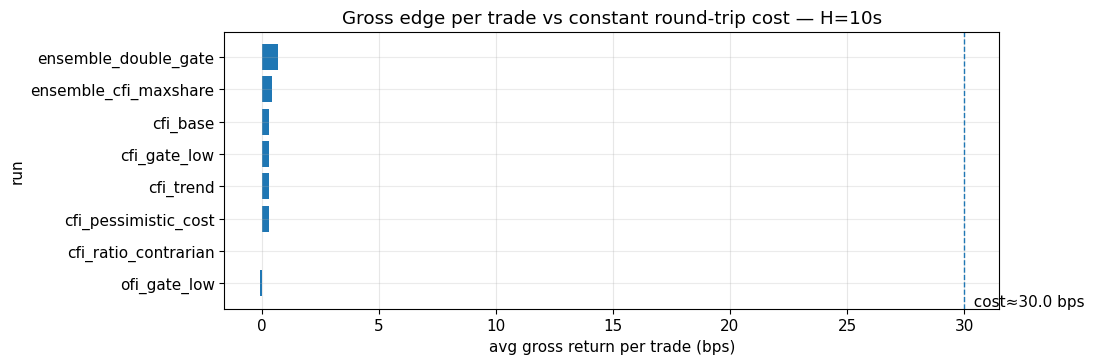

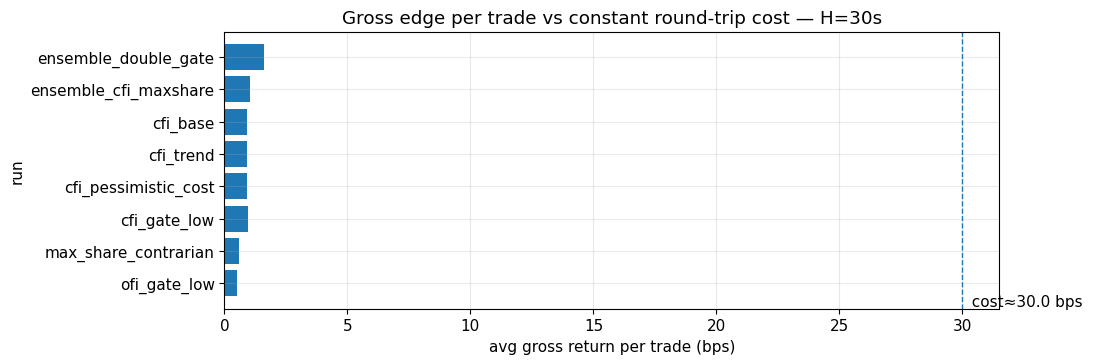

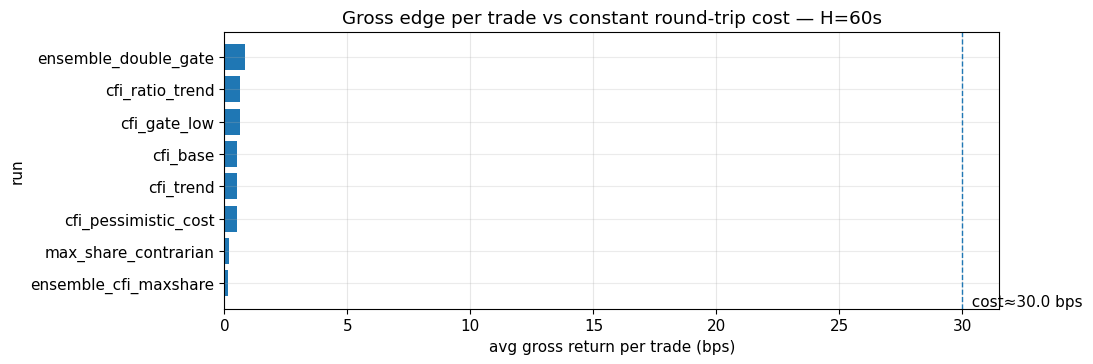

In [22]:
import matplotlib.pyplot as plt

def plot_edge_vs_cost(res: pd.DataFrame, H: int, top_k: int = 8):
    d = res[res["H"] == int(H)].copy()
    if d.empty:
        return

    # choose the best candidates by alpha_avg_pnl (or avg_pnl if alpha missing)
    sort_key = "alpha_avg_pnl" if d["alpha_avg_pnl"].notna().any() else "avg_pnl"
    d = d.sort_values(sort_key, ascending=False).head(int(top_k)).copy()

    # plot gross edge per trade; overlay cost
    y = d["run"].astype(str).to_list()
    x = d["avg_gross_ret_bps"].to_numpy(dtype="float64")
    cost_line = float(np.nanmedian(d["avg_cost_bps"].to_numpy(dtype="float64")))

    fig, ax = plt.subplots(figsize=(10, 0.45 * max(len(d), 6)))
    ax.barh(y, x)
    ax.axvline(cost_line, linestyle="--", linewidth=1)
    ax.invert_yaxis()
    ax.set_title(f"Gross edge per trade vs constant round-trip cost — H={int(H)}s")
    ax.set_xlabel("avg gross return per trade (bps)")
    ax.set_ylabel("run")
    ax.grid(True, axis="x", alpha=0.3)

    # small text: cost
    ax.text(cost_line, ax.get_ylim()[0], f"  cost≈{cost_line:.1f} bps", va="bottom")
    plt.show()

for H in sorted(res["H"].unique()):
    plot_edge_vs_cost(res, H, top_k=8)


Equity plots for H_focus: 30


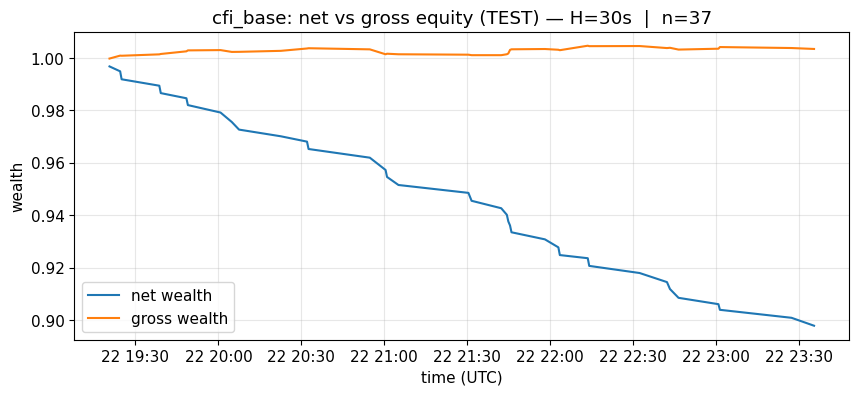

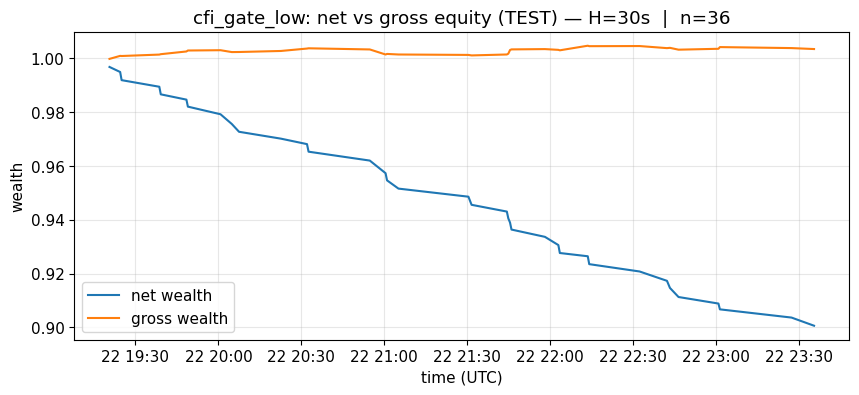

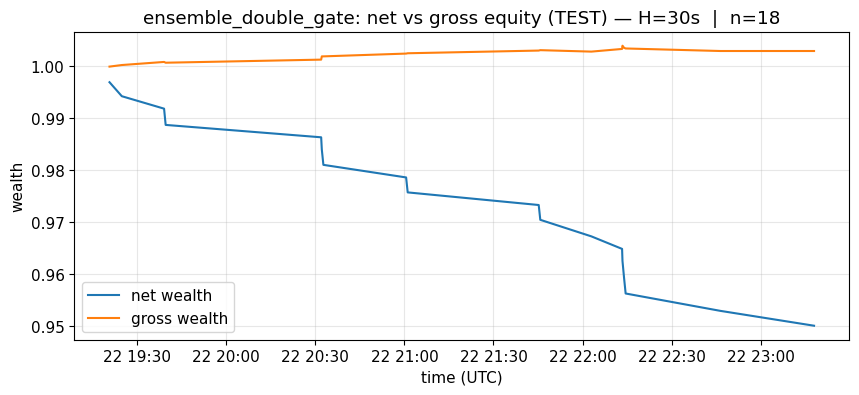

In [23]:
def plot_net_vs_gross_for_run(run: str, H: int):
    rd = REPORT_TABLES / run
    t = load_trades(rd, H)
    if t.empty:
        print(f"(skip) {run} H={H}: no trades")
        return

    t = t.sort_values("exit_time").copy()
    exit_time = t["exit_time"]

    pnl = t["pnl"].to_numpy(dtype="float64")
    gross = t["gross_ret"].to_numpy(dtype="float64")

    wealth_net = np.cumprod(1.0 + pnl)
    wealth_gross = np.cumprod(1.0 + gross)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(exit_time, wealth_net, label="net wealth")
    ax.plot(exit_time, wealth_gross, label="gross wealth")
    ax.set_title(f"{run}: net vs gross equity (TEST) — H={int(H)}s  |  n={len(t)}")
    ax.set_xlabel("time (UTC)")
    ax.set_ylabel("wealth")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)
    plt.show()

# pick a small, story-driven set (use those that exist)
preferred_runs = ["cfi_base", "cfi_gate_low", "ensemble_double_gate", "svi_base", "ofi_base", "ensemble_cfi_maxshare"]
existing_runs = [r for r in preferred_runs if (REPORT_TABLES / r).exists()]

# keep it minimal: plot for H=30 if available, else the smallest H
Hs_avail = sorted(res["H"].unique())
H_focus = 30 if 30 in Hs_avail else Hs_avail[0]

print("Equity plots for H_focus:", H_focus)
for r in existing_runs[:3]:
    plot_net_vs_gross_for_run(r, H_focus)


In [24]:
# how often TP is chosen (per run, per H)
pt_pivot = res.pivot(index="run", columns="H", values="pt_bps_chosen_tune").sort_index()
display(pt_pivot)

# aggregate view: distribution of chosen pt values
pt_counts = res["pt_bps_chosen_tune"].value_counts(dropna=False).sort_index()
print("\nChosen pt_bps counts (across all run x H rows):")
display(pt_counts.to_frame("count"))

# TP exit rate and holding time summary
cols = ["run", "H", "n_trades", "pt_bps_chosen_tune", "tp_exit_rate", "avg_hold_seconds"]
cols = [c for c in cols if c in res.columns]
tp_diag = res[cols].sort_values(["H", "tp_exit_rate"], ascending=[True, False])
display(tp_diag.head(20))


H,10,30,60
run,,,
cfi_base,0.0,0.0,25.0
cfi_contrarian,5.0,5.0,5.0
cfi_gate_low,0.0,0.0,25.0
cfi_pessimistic_cost,0.0,0.0,25.0
cfi_ratio_contrarian,0.0,10.0,0.0
cfi_ratio_trend,0.0,10.0,0.0
cfi_trend,0.0,0.0,25.0
ensemble_cfi_maxshare,0.0,5.0,0.0
ensemble_double_gate,0.0,5.0,0.0



Chosen pt_bps counts (across all run x H rows):


,count
pt_bps_chosen_tune,
0.0,25
5.0,5
10.0,8
25.0,10


,run,H,n_trades,pt_bps_chosen_tune,tp_exit_rate,avg_hold_seconds
15,cfi_contrarian,10,45,5.0,0.044444,9.911111
0,ensemble_double_gate,10,27,0.0,0.000000,10.000000
1,ensemble_cfi_maxshare,10,36,0.0,0.000000,10.000000
2,cfi_base,10,45,0.0,0.000000,10.000000
3,cfi_gate_low,10,45,0.0,0.000000,10.000000
4,cfi_trend,10,45,0.0,0.000000,10.000000
5,cfi_pessimistic_cost,10,45,0.0,0.000000,10.000000
6,cfi_ratio_contrarian,10,52,0.0,0.000000,10.000000
7,ofi_gate_low,10,53,10.0,0.000000,10.000000
8,svi_gate_low,10,53,10.0,0.000000,10.000000


## Results takeaways (TEST)

1. **Gross edge exists, but is small relative to transaction costs.**

   Across $H \in \{10,30,60\}$ the best runs have average gross return per trade on the order of **$\sim 0.3$–$1.6$ bps**, while the assumed round-trip cost is **$\approx 30$ bps**.
   As a result, net performance remains negative even when $\alpha_{\text{avg\_pnl}}$ is positive.


2. **Ensembles / CFI variants tend to dominate the top ranks, but sample size matters.**

   The ensemble runs often rank highly by $\alpha_{\text{avg\_pnl}}$, but some of these rows have **low $n$** (e.g. the double-gate at $H=30$).
   The “$n_{\text{trades}} \ge 30$” filter is therefore the more reliable view for comparisons.

3. **Equity curves make the cost drag.**

   Gross equity is roughly flat-to-slightly-up, while net equity decays almost monotonically, consistent with paying a large constant cost per trade.

4. **Take-profit rarely triggers in most configs.**

   Many tuned solutions pick $pt=0$; when $pt>0$, the observed $tp\_exit\_rate$ is often low and the average holding time stays close to the fixed horizon.
   This suggests that take-profit is not the primary driver of performance under this setup; turnover reduction and execution modeling likely matter more.


**Summary:** the pipeline identifies a small, directionally consistent signal. Under the assumed constant cost model, this edge is insufficient to produce positive net performance. The primary limitation in this setup is transaction cost, rather than backtest construction.




---

# 6. Baselines & statistical hygiene

## Random-sign baseline (Monte Carlo)

Each OOS (TEST) run is benchmarked against a **random-sign baseline** as a reference for expected performance under random trade direction.


This baseline preserves:
- **Exact TEST trade entry times** produced by the strategy (so turnover / timing / holding structure is unchanged),
- The same **holding window H** and the same **take-profit logic** (if `pt_bps > 0`),
- The same **open→open execution model** and the same constant **round-trip costs**.

It changes only one thing:
- The **trade direction** (long/short) is randomized independently per trade.

We run `baseline_trials` (default 500) and store `mean`, `p05`, and `p95` for `avg_pnl`, `total_return`, and `sharpe_trades`.

## Alpha definition (as computed in the report)

Per-trade alpha vs baseline is defined as:

$$
\alpha_{\text{avg\_pnl}} = \overline{pnl} - \mathbb{E}[\overline{pnl}_{\text{baseline}}]
$$

In the generated report tables this is exactly:

- `alpha_avg_pnl = avg_pnl - baseline_avg_pnl_mean`
- (and analogously `alpha_sharpe`, `alpha_total_return`)

> Note: the baseline also pays costs, so alpha isolates *directional information* over and above “same turnover + random side”.


In [25]:
from pathlib import Path
import numpy as np
import pandas as pd

TABLES_DIR = Path("reports/tables")

# Prefer the full table (has baseline p05/p95). Fallback to compact if needed.
candidates = [
    LB_PATH,
    TABLES_DIR / "leaderboard_compact.csv",
]
for p in candidates:
    if p.exists():
        lb = pd.read_csv(p)
        print(f"[OK] Loaded: {p} | rows={len(lb)} cols={lb.shape[1]}")
        break
else:
    raise FileNotFoundError(
        "Could not find leaderboard tables. Expected one of:\n"
        + "\n".join([str(x) for x in candidates])
    )

# Ensure alpha columns exist (report.py should already create them, but keep this robust)
if ("alpha_avg_pnl" not in lb.columns) and ("avg_pnl" in lb.columns) and ("baseline_avg_pnl_mean" in lb.columns):
    lb["alpha_avg_pnl"] = lb["avg_pnl"].astype(float) - lb["baseline_avg_pnl_mean"].astype(float)

# Convert key per-trade metrics to bps for readability
to_bps = [
    "avg_pnl",
    "baseline_avg_pnl_mean",
    "baseline_avg_pnl_p05",
    "baseline_avg_pnl_p95",
    "alpha_avg_pnl",
    "avg_cost",
]
for c in to_bps:
    if c in lb.columns:
        lb[c + "_bps"] = lb[c].astype(float) * 1e4

# Sanity check: alpha definition matches (avg_pnl - baseline_mean)
if all(c in lb.columns for c in ["alpha_avg_pnl", "avg_pnl", "baseline_avg_pnl_mean"]):
    err = np.nanmax(np.abs(lb["alpha_avg_pnl"] - (lb["avg_pnl"] - lb["baseline_avg_pnl_mean"])))
    print(f"[check] max|alpha_avg_pnl - (avg_pnl - baseline_avg_pnl_mean)| = {err:.3e}")

# Display: baseline summary for the top runs per H (by alpha_avg_pnl)
show_cols = [
    "run", "H", "n_trades",
    "avg_pnl_bps",
    "baseline_avg_pnl_mean_bps",
    "baseline_avg_pnl_p05_bps",
    "baseline_avg_pnl_p95_bps",
    "alpha_avg_pnl_bps",
    "baseline_trials",
    "baseline_total_return_mean",
    "baseline_total_return_p05",
    "baseline_total_return_p95",
]
# keep only those that exist in the loaded table
show_cols = [c for c in show_cols if c in lb.columns]

for H in sorted(lb["H"].dropna().unique()):
    d = lb[lb["H"] == H].copy()

    # pick the most informative ranking available
    rank_col = "alpha_avg_pnl" if "alpha_avg_pnl" in d.columns else ("avg_pnl" if "avg_pnl" in d.columns else None)
    if rank_col is None:
        print(f"\n=== H={int(H)}s: (no alpha/avg_pnl columns found) ===")
        display(d.head(5))
        continue

    d = d.sort_values(rank_col, ascending=False).head(5)
    print(f"\n=== H={int(H)}s: TOP 5 by {rank_col} (TEST) — baseline diagnostics ===")
    display(d[show_cols])

# Optional: show how close baseline mean is to "just paying costs" (when avg_cost exists)
if ("avg_cost_bps" in lb.columns) and ("baseline_avg_pnl_mean_bps" in lb.columns):
    tmp = lb.groupby("H", as_index=False).agg(
        baseline_mean_bps=("baseline_avg_pnl_mean_bps", "mean"),
        avg_cost_bps=("avg_cost_bps", "mean"),
    )
    tmp["baseline_minus_cost_bps"] = tmp["baseline_mean_bps"] + tmp["avg_cost_bps"]
    print("\n[baseline vs cost] (baseline mean should be close to -cost if returns have ~0 mean under random sign):")
    display(tmp.sort_values("H"))


[OK] Loaded: /Users/noelp/PycharmProjects/microstructure-signal-research/reports/tables/summary_best_oos_all_runs.csv | rows=48 cols=48
[check] max|alpha_avg_pnl - (avg_pnl - baseline_avg_pnl_mean)| = 2.033e-19

=== H=10s: TOP 5 by alpha_avg_pnl (TEST) — baseline diagnostics ===


,run,H,n_trades,avg_pnl_bps,baseline_avg_pnl_mean_bps,baseline_avg_pnl_p05_bps,baseline_avg_pnl_p95_bps,alpha_avg_pnl_bps,baseline_trials,baseline_total_return_mean,baseline_total_return_p05,baseline_total_return_p95
8,ensemble_double_gate,10,27,-29.285685,-29.990078,-30.970377,-29.004484,0.704393,500,-0.077894,-0.080340,-0.075431
7,ensemble_cfi_maxshare,10,36,-29.546974,-29.972338,-30.792881,-29.264665,0.425364,500,-0.102428,-0.105085,-0.100133
0,cfi_base,10,45,-29.682523,-29.994200,-30.732777,-29.242434,0.311678,500,-0.126439,-0.129348,-0.123471
2,cfi_gate_low,10,45,-29.682523,-29.994200,-30.732777,-29.242434,0.311678,500,-0.126439,-0.129348,-0.123471
6,cfi_trend,10,45,-29.682523,-29.994200,-30.732777,-29.242434,0.311678,500,-0.126439,-0.129348,-0.123471



=== H=30s: TOP 5 by alpha_avg_pnl (TEST) — baseline diagnostics ===


,run,H,n_trades,avg_pnl_bps,baseline_avg_pnl_mean_bps,baseline_avg_pnl_p05_bps,baseline_avg_pnl_p95_bps,alpha_avg_pnl_bps,baseline_trials,baseline_total_return_mean,baseline_total_return_p05,baseline_total_return_p95
24,ensemble_double_gate,30,18,-28.394673,-30.100375,-31.751140,-28.478806,1.705702,500,-0.052816,-0.055637,-0.050041
23,ensemble_cfi_maxshare,30,23,-28.961109,-30.091400,-31.347040,-28.840961,1.130292,500,-0.066967,-0.069668,-0.064273
19,cfi_pessimistic_cost,30,37,-39.066488,-40.065231,-41.742766,-38.352332,0.998743,500,-0.138034,-0.143395,-0.132538
16,cfi_base,30,37,-29.066488,-30.065231,-31.742766,-28.352332,0.998743,500,-0.105427,-0.110986,-0.099729
22,cfi_trend,30,37,-29.066488,-30.065231,-31.742766,-28.352332,0.998743,500,-0.105427,-0.110986,-0.099729



=== H=60s: TOP 5 by alpha_avg_pnl (TEST) — baseline diagnostics ===


,run,H,n_trades,avg_pnl_bps,baseline_avg_pnl_mean_bps,baseline_avg_pnl_p05_bps,baseline_avg_pnl_p95_bps,alpha_avg_pnl_bps,baseline_trials,baseline_total_return_mean,baseline_total_return_p05,baseline_total_return_p95
40,ensemble_double_gate,60,36,-29.172276,-30.066857,-31.544173,-28.727597,0.894581,500,-0.102735,-0.107513,-0.098390
37,cfi_ratio_trend,60,33,-29.360670,-30.094797,-31.799249,-28.275897,0.734127,500,-0.094677,-0.099775,-0.089215
34,cfi_gate_low,60,28,-29.363400,-30.095959,-32.674504,-27.481625,0.732558,500,-0.080933,-0.087573,-0.074169
35,cfi_pessimistic_cost,60,29,-39.487741,-40.007298,-42.648453,-37.546316,0.519557,500,-0.109751,-0.116580,-0.103358
32,cfi_base,60,29,-29.487741,-30.007298,-32.648453,-27.546316,0.519557,500,-0.083462,-0.090486,-0.076887



[baseline vs cost] (baseline mean should be close to -cost if returns have ~0 mean under random sign):


,H,baseline_mean_bps,avg_cost_bps,baseline_minus_cost_bps
0,10,-31.886780,31.875,-0.011780
1,30,-31.929447,31.875,-0.054447
2,60,-31.945716,31.875,-0.070716


## Multiple testing / p-hacking hygiene (what we did)

- We keep the “core” signal set small (CFI + max_share; SVI/OFI only as replication controls).
- Hyperparameters are tuned on **VAL only**; TEST is untouched.
- We report OOS sensitivity via the grid CSVs and the aggregated leaderboard (optional figures can be generated offline via `report.py`).





---

# 7. Failure modes / diagnostics

This section summarizes the main limitations observed when evaluating microstructure-style signals on public 1-second data.


Key failure modes observed here:

- **Cost dominance (primary):** best gross edge per trade is on the order of ~0.3–1.6 bps, while the assumed **round-trip cost is ~30 bps** (or 40 bps in the pessimistic runs). Net PnL is therefore negative even when the signal has positive alpha vs the random baseline.
- **Sample size:** some configurations have low trade counts on TEST (e.g. `ensemble_double_gate` at H=30s with n≈18). Treat these as exploratory rather than “production-ready”.
- **Edge fragility / boundary solutions:** the tuning often selects parameters at the edges of the grid (e.g. `pt_bps` at 0 or max). This can indicate weak sensitivity, insufficient grid resolution, or that take-profit adds limited incremental value under this execution model.
- **Imputed trades (data-quality note):** `trades_1s` has a non-trivial imputation rate. Some signals (notably ratio-style variants) may trigger relatively more often on imputed seconds, which we track explicitly.


In [26]:
MIN_TRADES = 30

# 1) Cost dominance summary (TEST)
summary = (
    res.groupby("H")
       .agg(
           rows=("run", "size"),
           best_gross_bps=("avg_gross_ret_bps", "max"),
           median_gross_bps=("avg_gross_ret_bps", "median"),
           median_cost_bps=("avg_cost_bps", "median"),
           best_alpha_bps=("alpha_avg_pnl_bps", "max"),
           best_net_avg_pnl_bps=("avg_pnl_bps", "max"),
       )
       .reset_index()
)
display(summary)

# 2) Sample size: which TEST rows are underpowered?
low_n = (
    res[res["n_trades"] < MIN_TRADES]
    .loc[:, ["run","H","n_trades","avg_gross_ret_bps","avg_cost_bps","avg_pnl_bps","alpha_avg_pnl_bps"]]
    .sort_values(["H","n_trades","alpha_avg_pnl_bps"], ascending=[True, True, False])
)
display(low_n)

# 3) Edge fragility: how often did tuning pick grid boundaries?
q_candidates = sorted(set(payload.get("q_list", []))) if "payload" in globals() else sorted(res["q_chosen_tune"].dropna().unique().tolist())
pt_candidates = sorted(set(payload.get("pt_bps_list", []))) if "payload" in globals() else sorted(res["pt_bps_chosen_tune"].dropna().unique().tolist())

q_min, q_max = (q_candidates[0], q_candidates[-1]) if len(q_candidates) else (np.nan, np.nan)
pt_min, pt_max = (pt_candidates[0], pt_candidates[-1]) if len(pt_candidates) else (np.nan, np.nan)

edge = res.copy()
edge["q_edge"] = edge["q_chosen_tune"].isin([q_min, q_max])
edge["pt_edge"] = edge["pt_bps_chosen_tune"].isin([pt_min, pt_max])
edge["any_edge"] = edge["q_edge"] | edge["pt_edge"]
edge["both_edges"] = edge["q_edge"] & edge["pt_edge"]

edge_summary = pd.Series(
    {
        "total_rows": int(len(edge)),
        "q_min": q_min, "q_max": q_max,
        "pt_min": pt_min, "pt_max": pt_max,
        "q_edge_count": int(edge["q_edge"].sum()),
        "pt_edge_count": int(edge["pt_edge"].sum()),
        "any_edge_count": int(edge["any_edge"].sum()),
        "both_edges_count": int(edge["both_edges"].sum()),
        "any_edge_rate": float(edge["any_edge"].mean()),
        "both_edges_rate": float(edge["both_edges"].mean()),
    }
)
display(edge_summary)



,H,rows,best_gross_bps,median_gross_bps,median_cost_bps,best_alpha_bps,best_net_avg_pnl_bps
0,10,16,0.714315,-0.055436,30.0,0.704393,-29.285685
1,30,16,1.605327,0.528053,30.0,1.705702,-28.394673
2,60,16,0.827724,-0.124513,30.0,0.894581,-29.172276


,run,H,n_trades,avg_gross_ret_bps,avg_cost_bps,avg_pnl_bps,alpha_avg_pnl_bps
0,ensemble_double_gate,10,27,0.714315,30.0,-29.285685,0.704393
16,ensemble_double_gate,30,18,1.605327,30.0,-28.394673,1.705702
17,ensemble_cfi_maxshare,30,23,1.038891,30.0,-28.961109,1.130292
29,cfi_ratio_trend,30,26,-0.003836,30.0,-30.003836,-0.013410
23,ofi_gate_low,30,29,0.528053,30.0,-29.471947,0.487771
24,svi_gate_low,30,29,0.528053,30.0,-29.471947,0.487771
31,cfi_contrarian,30,29,-1.407283,30.0,-31.407283,-1.030461
38,max_share_contrarian,60,26,0.171124,30.0,-29.828876,0.156942
34,cfi_gate_low,60,28,0.636600,30.0,-29.363400,0.732558
35,cfi_base,60,29,0.512259,30.0,-29.487741,0.519557


total_rows           48.000000
q_min                 1.000000
q_max                 3.000000
pt_min                0.000000
pt_max              100.000000
q_edge_count         17.000000
pt_edge_count        25.000000
any_edge_count       32.000000
both_edges_count     10.000000
any_edge_rate         0.666667
both_edges_rate       0.208333
dtype: float64

In [27]:
# Requires: trd_imp from the earlier data sanity check cell, and imp_decisions from the "decision_on_imputed_trades" table.
if "imp_decisions" in globals() and "trd_imp" in globals():
    tmp = imp_decisions.copy()
    tmp["excess_vs_global_imputed"] = tmp["decision_on_imputed_trades"] - float(trd_imp)
    tmp = tmp.sort_values("decision_on_imputed_trades", ascending=False)

    display(tmp.head(12)[["run","H","decision_on_imputed_trades","excess_vs_global_imputed"]])
else:
    print("Missing `imp_decisions` and/or `trd_imp` (run the earlier data-quality cells first).")


,run,H,decision_on_imputed_trades,excess_vs_global_imputed
32,cfi_ratio_contrarian,60,0.181818,0.120986
33,cfi_ratio_trend,60,0.181818,0.120986
34,max_share_contrarian,60,0.153846,0.093014
16,cfi_ratio_trend,30,0.153846,0.093014
17,cfi_ratio_contrarian,30,0.136364,0.075531
0,cfi_ratio_contrarian,10,0.134615,0.073783
1,cfi_ratio_trend,10,0.134615,0.073783
35,ensemble_cfi_maxshare,60,0.100000,0.039167
18,max_share_contrarian,30,0.088235,0.027403
3,svi_gate_low,10,0.075472,0.014639


## Evidence from this run (tables above)

- **Cost dominance:** the summary-by-H table shows best gross edges remain sub-2 bps while median round-trip cost is ~30 bps, so best net avg PnL stays ≈ −28/−29 bps per trade.
- **Sample size:** the low-`n_trades` table enumerates underpowered TEST rows (n < 30), including the `ensemble_double_gate` case at H=30s.
- **Edge fragility:** the boundary-counts output quantifies how often tuning lands on grid edges (`any_edge`, `pt_edge`, `q_edge`, `both_edges`).
- **Imputed-trades sensitivity:** the imputed-decisions table reports `decision_on_imputed_trades` and its excess vs the global imputation rate, highlighting ratio-style variants as a data-quality note.



---

# 8. What I’d do next

This notebook intentionally shows a “realistic-first” result: a small gross edge that is dominated by execution frictions at 1s frequency.
The most valuable next steps are therefore execution + turnover control + robustness checks:

1) **Better cost model (still simple, but less naive)**
   - Replace constant slippage with a proxy tied to market conditions:
     spread proxy (e.g., high–low / close, or RV), volatility-scaled slippage, and/or volume-normalized impact.
   - Stress-test costs across regimes (quiet vs active) to see where the strategy could survive.

2) **Reduce turnover (make the edge “bite”)**
   - Stronger thresholding (larger q), **debounce/cooldown**, and/or signal persistence (require k consecutive seconds).
   - Position sizing by signal strength and/or intensity to concentrate on the best opportunities.

3) **Walk-forward / rolling validation**
   - Rolling train→val→test windows to quantify stability and avoid “one-day lucky” effects.
   - Track parameter drift (q/pt) and performance dispersion across time slices.

4) **Regime gating beyond intensity**
   - Use intensity + realized volatility to activate/deactivate the strategy.
   - Explicitly learn “when not to trade” (most of the edge is likely regime-dependent).

5) **Oracle upper bound (diagnostic, not tradable)**
   - Compute a hindsight **non-overlapping optimal exit/entry schedule** (or best-of-H / best-of-TP within the window)
     to estimate the theoretical upper bound of the signal given this data.
   - If the oracle improvement is small, the edge is likely noise-limited; if large, the problem is primarily execution/turnover.

6) **Forward-only L2 snapshots (no historical replay)**
   - Collect live order book snapshots going forward to validate whether CFI/max_share correlate with queue/spread dynamics.
   - This keeps the project honest while enabling a stronger microstructure link.


---

# 9. Conclusions (key takeaways)

1) **Cross-source validation:** Binance 1s klines and aggTrades replicate the same imbalance signal (SVI ≈ OFI),
   which is a strong check that the pipeline and feature definitions are consistent.

2) **Distinct information:** CFI-style signals (and max_share concentration) behave differently from SVI/OFI-style imbalance,
   and simple ensembles can improve the *gross* edge relative to single-signal baselines.

3) **Costs dominate at 1s:** with an event-driven backtest and explicit round-trip costs,
   the observed gross edge (sub-2 bps per trade) is far below frictions (~30–40 bps), so net PnL is negative under this model.
   This clarifies the roadmap: execution modeling, turnover reduction, and regime control.
